# Data Preprocessing

In [1]:
import scanpy as sc
import anndata as ad
import scipy
import seaborn as sns
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA


from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics.pairwise import pairwise_distances, rbf_kernel
from scipy.spatial.distance import pdist,squareform
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset,DataLoader, TensorDataset, random_split
from torch.distributions import LogNormal
from torch.optim.lr_scheduler import StepLR



import matplotlib.pyplot as plt
from umap import UMAP
from matplotlib.colors import ListedColormap
from matplotlib import cm
import scipy.sparse

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, silhouette_score
from sklearn.cluster import KMeans
from sklearn.neighbors import NearestNeighbors
from scipy.stats import spearmanr
from scipy import stats
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score

import warnings
warnings.filterwarnings('ignore')
from typing import Tuple




/opt/conda/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
adata = ad.read_h5ad('./data/tabula_muris.h5ad')
print(adata)
print(adata.X.min())
print(adata.X.max())
top_10_classes = adata.obs['cell_ontology_class'].value_counts().sort_values(ascending=False).head(10).index.tolist()
# subseting anndata base on cell_ontology_class
adata_sub = adata[adata.obs['cell_ontology_class'].isin(top_10_classes)].copy()

adata_sub.layers['raw_counts'] = adata_sub.X.copy()


AnnData object with n_obs × n_vars = 45602 × 128
    obs: 'age', 'cell', 'cell_ontology_class', 'cell_ontology_id', 'free_annotation', 'method', 'mouse.id', 'n_genes', 'sex', 'subtissue', 'tissue', 'tissue_free_annotation'
    var: 'n_cells'
0.0
9.409437


# Distribution of gene expressions for each cell types

# Amount of samples for each classes

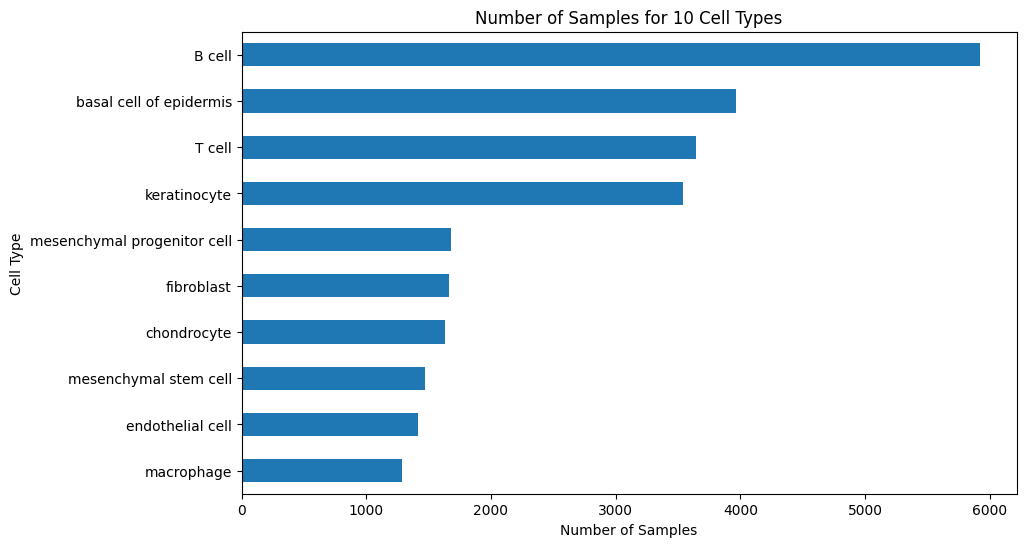

In [3]:
top_10_class_counts = adata_sub.obs['cell_ontology_class'].value_counts().sort_values(ascending=False).head(10)

plt.figure(figsize=(10,6))
top_10_class_counts.plot(kind='barh')
plt.xlabel('Number of Samples')
plt.ylabel('Cell Type')
plt.title('Number of Samples for 10 Cell Types')
plt.gca().invert_yaxis()
plt.show()

In [4]:
for cell_type, count in top_10_class_counts.items():
    print(f"{cell_type}: {count}")

B cell: 5918
basal cell of epidermis: 3964
T cell: 3643
keratinocyte: 3536
mesenchymal progenitor cell: 1676
fibroblast: 1666
chondrocyte: 1630
mesenchymal stem cell: 1468
endothelial cell: 1418
macrophage: 1290


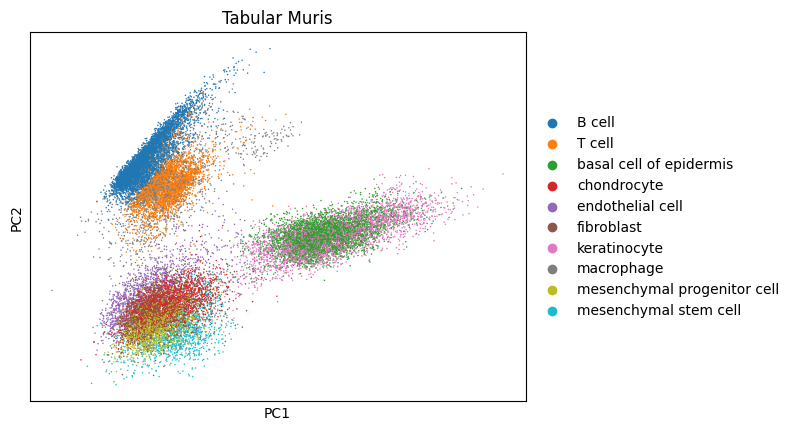

In [5]:
# run pca to select highly variable genes
sc.pp.pca(adata_sub, n_comps=50)
# plot pca
sc.pl.pca(adata_sub, color='cell_ontology_class', title='Tabular Muris',show=True)
# save pca layers
adata_sub.obsm['X_pca'] = adata_sub.obsm['X_pca'].copy()


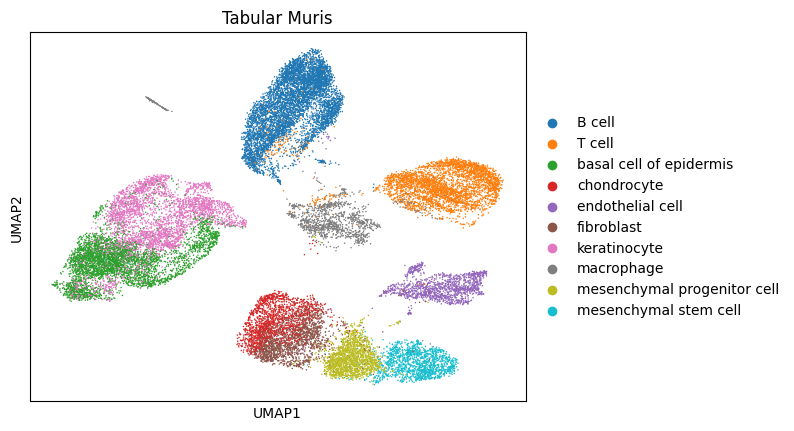

In [6]:
# running umap
sc.pp.neighbors(adata_sub)
sc.tl.umap(adata_sub)
# plot umap
sc.pl.umap(adata_sub, color='cell_ontology_class',title='Tabular Muris', show=True)


Interpretation: The data seems cluster together, with B cell, T cell and mesenchymal are in separate cluster. Meanwhile basal and keratino are in the same cluster.

# Implementing Stable Diffusion model

In [18]:
##############################################
# 1. CONFIGURATION 
##############################################

class Config:
    # Data params
    batch_size = 320
    num_timesteps = 1000
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Model params
    input_dim = None  # set after loading data
    num_classes = None  # set after encoding labels
    hidden_dim = 512
    time_emb_dim = 128
    label_emb_dim = 128
    num_res_blocks = 6
    lr = 1e-3
    max_epochs = 1000

    # Early stopping
    patience = 20

    # Sampling params for log-normal prior
    log_prior_mu = 0
    log_prior_sigma = 1
    eps = 1e-6

    # Noise scheduler
    schedule_type = 'linear'

config = Config()


##############################################
# 2. UTILITIES
##############################################

def compute_pdist(X, Y=None, metric='euclidean'):
    if Y is None:
        Y = X
    return pairwise_distances(X, Y, metric=metric, n_jobs=-1)

def energy_distance(X, Y):
    XX = compute_pdist(X)
    YY = compute_pdist(Y)
    XY = compute_pdist(X, Y)
    return np.sqrt(2*np.mean(XY) - np.mean(XX) - np.mean(YY))

def classwise_energy_distance(real_data, generated_data, labels_encoded, generated_labels):
    energy_distances = []
    print("Energy Distance (per class):")
    for cls in np.unique(labels_encoded):
        real_cls_data = real_data[labels_encoded == cls]
        gen_cls_data = generated_data[generated_labels == cls]

        ed_cls = energy_distance(real_cls_data, gen_cls_data)
        energy_distances.append(ed_cls)

        class_name = le.inverse_transform([cls])[0]
        print(f"Class {class_name}: {ed_cls:.4f}")

    avg_ed = np.mean(energy_distances)
    return avg_ed


def mmd_rbf(X, Y, gamma=None):
    if gamma is None:
        gamma = 1.0 / X.shape[1]
    XX = rbf_kernel(X, X, gamma)
    YY = rbf_kernel(Y, Y, gamma)
    XY = rbf_kernel(X, Y, gamma)
    return XX.mean() + YY.mean() - 2 * XY.mean()

def classwise_mmd(real_data, generated_data, labels_encoded, generated_labels):
    mmd_scores = []
    print("MMD (per class):")
    for cls in np.unique(labels_encoded):
        real_cls_data = real_data[labels_encoded == cls]
        gen_cls_data = generated_data[generated_labels == cls]

        mmd_cls = mmd_rbf(real_cls_data, gen_cls_data)
        mmd_scores.append(mmd_cls)

        class_name = le.inverse_transform([cls])[0]
        print(f"Class {class_name}: {mmd_cls:.4f}")

    avg_mmd = np.mean(mmd_scores)
    return avg_mmd


##############################################
# 3. MODEL IMPLEMENTATION
##############################################
class SinusoidalPosEmb(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, t):
        device = t.device
        half_dim = self.dim // 2
        emb = torch.exp(torch.arange(half_dim, device=device) * -(torch.log(torch.tensor(10000.0)) / (half_dim - 1)))
        emb = t[:, None] * emb[None, :]
        emb = torch.cat([torch.sin(emb), torch.cos(emb)], dim=-1)
        return emb

class ResidualBlock(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.net = nn.Sequential(
            DenseBatchNorm(dim, dim*2,  activation='relu'),
            DenseBatchNorm(dim*2, dim)
        )
    def forward(self, x):
        return x + self.net(x)

class DenseBatchNorm(nn.Module):
    def __init__(self,in_units,out_units,activation=None):
        super().__init__()
        layers = [
            nn.Linear(in_units,out_units),
            nn.BatchNorm1d(out_units)
        ]
        if activation == 'relu':
            layers.append(nn.ReLU())
        self.dense_bn_act = nn.Sequential(*layers)

    def forward(self,x):
        return self.dense_bn_act(x)

class StableDiffusion(nn.Module):
    def __init__(self, input_dim, num_classes, hidden_dim=256, time_emb_dim=128, label_emb_dim=128, num_res_blocks=4):
        super().__init__()
        self.time_embedding = SinusoidalPosEmb(time_emb_dim)
        self.time_mlp = DenseBatchNorm(time_emb_dim, hidden_dim, activation='relu')
        self.label_embedding = nn.Embedding(num_classes, label_emb_dim)
        self.init_proj = DenseBatchNorm(input_dim + hidden_dim + label_emb_dim,
                                             hidden_dim, activation='relu')
        self.res_blocks = nn.ModuleList([ResidualBlock(hidden_dim) for _ in range(num_res_blocks)])
        self.final_layer = nn.Linear(hidden_dim, input_dim)

    def forward(self, x, t, labels):
        t_emb = self.time_embedding(t)
        t_emb = self.time_mlp(t_emb)
        label_emb = self.label_embedding(labels)
        h = torch.cat([x, t_emb, label_emb], dim=-1)
        h = self.init_proj(h)
        for block in self.res_blocks:
            h = block(h)
        return self.final_layer(h)


class DiffusionProcess:
    def __init__(self,input_dim,num_timesteps=1000,beta_start=1e-5,
                 beta_end=0.02, schedule_type=config.schedule_type):
        self.input_dim = input_dim
        self.num_timesteps = num_timesteps

        if schedule_type == 'linear':
            beta = torch.linspace(beta_start, beta_end, num_timesteps)
        elif schedule_type == 'cosine':
            beta = self._cosine_schedule(num_timesteps)
        else:
            raise ValueError("Unsupported schedule type. Use 'linear' or 'cosine'.")

        self.beta = beta
        self.alpha = 1 - beta
        self.alpha_bar = torch.cumprod(self.alpha, dim=0)

    def _cosine_schedule(self, num_timesteps, s=0.008):
        steps = torch.arange(num_timesteps + 1)/ num_timesteps
        alpha_bar = torch.cos((steps + s) / (1 + s) * torch.pi * 0.5) ** 2
        alpha_bar = alpha_bar / alpha_bar[0]
        beta = 1 - alpha_bar[1:] / alpha_bar[:-1]
        return torch.clamp(beta, 1e-4, 0.9999)

    def add_noise(self, x, t):
        noise = torch.randn_like(x)
        alpha_bar_t = self.alpha_bar[t]
        noisy_x = torch.sqrt(alpha_bar_t) * x + torch.sqrt(1 - alpha_bar_t) * noise
        return noisy_x, noise

class DiffusionProcessLogNormal:
    def __init__(self, input_dim, num_timesteps=1000, beta_start=1e-5, 
                 beta_end=0.02, schedule_type=config.schedule_type, 
                 mu=config.log_prior_mu, 
                 sigma=config.log_prior_sigma,clip_std=4.0):
        self.input_dim = input_dim
        self.mu = mu
        self.sigma = sigma
        self.num_timesteps = num_timesteps

        if schedule_type == 'linear':
            beta = torch.linspace(beta_start, beta_end, num_timesteps)
        elif schedule_type == 'cosine':
            beta = self._cosine_schedule(num_timesteps)
        else:
            raise ValueError("Unsupported schedule type. Use 'linear' or 'cosine'.")

        self.beta = beta
        self.alpha = 1 - beta
        self.alpha_bar = torch.cumprod(self.alpha, dim=0)
        self.lognormal = torch.distributions.LogNormal(self.mu, self.sigma)
        self.clip_std   = clip_std # to avoid too extreme value caused by log-normal

    def _cosine_schedule(self, num_timesteps, s=0.008):
        steps = torch.arange(num_timesteps + 1)/ num_timesteps
        alpha_bar = torch.cos((steps + s) / (1 + s) * torch.pi * 0.5) ** 2
        alpha_bar = alpha_bar / alpha_bar[0]
        alpha_bar[-1] =0.0
        beta = 1 - alpha_bar[1:] / alpha_bar[:-1]
        return torch.clamp(beta, 1e-4, 0.9999)

    def add_noise(self, x, t):
        # original data has been log-trans, need to convert back to linear scale
        x_lin = torch.expm1(x)
        log_normal_noise = self.lognormal.sample(x_lin.shape)
        log_normal_noise = torch.clamp(log_normal_noise,
                        self.lognormal.mean - self.clip_std*self.lognormal.stddev,
                        self.lognormal.mean + self.clip_std*self.lognormal.stddev)
        log_normal_noise  = torch.exp(log_normal_noise)

        alpha_bar_t = self.alpha_bar[t]
        noisy_x = torch.sqrt(alpha_bar_t) * x_lin + torch.sqrt(1 - alpha_bar_t) * log_normal_noise

        # convert back to log space
        x_noisy_log = torch.log1p(noisy_x)
        return x_noisy_log, torch.log1p(log_normal_noise)

class DiffusionDataset(Dataset):
    def __init__(self,X,labels,diffusion,num_timesteps):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.labels = torch.tensor(labels, dtype=torch.long)
        self.diffusion = diffusion
        self.num_timesteps = num_timesteps

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        x = self.X[idx]
        t = torch.randint(0, self.diffusion.num_timesteps, ()).long()
        label = self.labels[idx]
        x_noisy, noise = self.diffusion.add_noise(x, t)
        return (x_noisy,t,label), noise

def prepare_dataset(X,labels,diffusion,batch_size,num_timesteps=1000):
    dataset = DiffusionDataset(X, labels,diffusion, num_timesteps)
    dataloader = DataLoader(dataset,
                            batch_size=batch_size,
                            shuffle=True,
                            pin_memory=True)
    return dataloader


class DiffusionDatasetLog(Dataset):
    def __init__(self, X, labels, diffusion, num_timesteps, eps=1e-6):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.labels = torch.tensor(labels, dtype=torch.long)
        self.diffusion = diffusion
        self.num_timesteps = num_timesteps

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        x_log = self.X[idx]
        t = torch.randint(0,self.diffusion.num_timesteps, ()).long()
        label = self.labels[idx]
        x_noisy, noise = self.diffusion.add_noise(x_log, t)
        return (x_noisy, t, label), noise

def prepare_dataset_log(X, labels, diffusion, batch_size, num_timesteps=1000):
    dataset = DiffusionDatasetLog(X, labels, diffusion, num_timesteps)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, pin_memory=True)
    return dataloader



##############################################
# 4. SAMPLING
##############################################

def sample(models,diffusion,labels,num_samples,device='cuda'):
    if not isinstance(models, list):
        models = [models]

    samples = torch.randn(num_samples, diffusion.input_dim).to(device)

    for t in reversed(range(diffusion.num_timesteps)):
        timestep = torch.full((num_samples,), t, dtype=torch.long).to(device)

        pred_noise = torch.zeros_like(samples).to(device)
        for model in models:
            model.eval()
            with torch.no_grad():
                pred = model(samples, timestep, labels)
            pred_noise += pred
        pred_noise /= len(models)

        alpha_bar_t = diffusion.alpha_bar[t].to(device)
        alpha_bar_prev = diffusion.alpha_bar[t-1].to(device) if t > 0 else torch.tensor(1.0).to(device)
        alpha_t = alpha_bar_t/alpha_bar_prev

        coef = diffusion.beta[t].to(device)/torch.sqrt(1 - alpha_bar_t)

        samples = (samples - coef * pred_noise) / torch.sqrt(alpha_t)
        if t > 0:
            noise = torch.randn_like(samples)
            samples += torch.sqrt(diffusion.beta[t]) * noise

    return samples.cpu().numpy()

def sample_log_normal(model,diffusion,labels,num_samples,device='cuda'):
    
    log_normal_dist = torch.distributions.LogNormal(config.log_prior_mu, config.log_prior_sigma)
    lin0 = log_normal_dist.sample((num_samples, config.input_dim)).to(device)
    samples_log = torch.log1p(lin0)

    for t in reversed(range(diffusion.num_timesteps)):
        timestep = torch.full((num_samples,), t, dtype=torch.long).to(device)
        pred_noise = torch.zeros_like(samples_log).to(device)

        model.eval()
        with torch.no_grad():
            pred = model(samples_log, timestep, labels)
        pred_noise += pred

        alpha_bar_t = diffusion.alpha_bar[t].to(device)
        alpha_bar_prev = diffusion.alpha_bar[t-1].to(device) if t > 0 else torch.tensor(1.0).to(device)
        alpha_t = alpha_bar_t / alpha_bar_prev

        coef = diffusion.beta[t].to(device) / torch.sqrt(1 - alpha_bar_t)

        x_lin = torch.expm1(samples_log)
        updated = (x_lin - coef * pred_noise) / torch.sqrt(alpha_t)
        if t > 0:
            noise = torch.randn_like(updated)
            updated += torch.sqrt(diffusion.beta[t]) * noise

    # Put in the range 0-10 to avoid extreme value
        samples_log = torch.log1p(updated.clamp(min=0))

    return samples_log

##############################################
# 5. GENERATE SYNTHETIC DATA
##############################################

def generate_synthetic_data(model, diffusion, labels_encoded, num_samples_per_class, device):
    model.eval()
    unique_labels = np.unique(labels_encoded)
    generated_data = []
    generated_labels = []

    for label in unique_labels:
        label_tensor = torch.full((num_samples_per_class,), label, dtype=torch.long).to(device)
        samples = sample(model, diffusion, label_tensor, num_samples_per_class, device=device)
        generated_data.append(samples)
        generated_labels.extend([label] * num_samples_per_class)

    generated_data = np.vstack(generated_data)
    generated_labels = np.array(generated_labels)
    return generated_data, generated_labels

def generate_synthetic_data_log(model, diffusion, labels_encoded, num_samples_per_class, device):
    model.eval()
    unique_labels = np.unique(labels_encoded)
    generated_data = []
    generated_labels = []

    for label in unique_labels:
        label_tensor = torch.full((num_samples_per_class,), label, dtype=torch.long).to(device)
        samples = sample_log_normal(model, diffusion, label_tensor, num_samples_per_class, device=device)
        generated_data.append(samples.cpu().numpy())
        generated_labels.extend([label] * num_samples_per_class)

    generated_data = np.vstack(generated_data)
    generated_labels = np.array(generated_labels)

    return generated_data, generated_labels


##############################################
# 6. TRAINING LOOP
##############################################

def train_loop(config, model, train_loader, val_loader):
    optimizer = torch.optim.Adam(model.parameters(), lr=config.lr)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)
    best_val_loss = float('inf')
    trigger_times = 0

    train_losses = []
    val_losses = []

    for epoch in range(config.max_epochs):
        model.train()
        train_loss_accum = 0.0
        num_batches = 0

        for (x_noisy, t, label_batch), noise in train_loader:
            x_noisy = x_noisy.to(config.device)
            t = t.to(config.device)
            label_batch = label_batch.to(config.device)
            noise = noise.to(config.device)

            pred_noise = model(x_noisy, t, label_batch)
            loss = F.mse_loss(pred_noise, noise)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss_accum += loss.item()
            num_batches += 1

        avg_train_loss = train_loss_accum / num_batches
        train_losses.append(avg_train_loss)

        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for (x_noisy, t, label_batch), noise in val_loader:
                x_noisy = x_noisy.to(config.device)
                t = t.to(config.device)
                label_batch = label_batch.to(config.device)
                noise = noise.to(config.device)

                pred_noise = model(x_noisy, t, label_batch)
                val_loss += F.mse_loss(pred_noise, noise).item()
        val_loss /= len(val_loader)
        val_losses.append(val_loss)

        print(f"Epoch {epoch+1}/{config.max_epochs} - Train Loss: {avg_train_loss:.6f} - Val Loss: {val_loss:.6f}")

        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            trigger_times = 0
        else:
            trigger_times += 1
            if trigger_times >= config.patience:
                print(f"Early stopping triggered at epoch {epoch+1}")
                break
        scheduler.step()
    return train_losses, val_losses


def train_loop_log(config, model, train_loader, val_loader):
    
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4) 
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)
    best_val_loss = float('inf')
    trigger_times = 0

    train_losses = []
    val_losses = []

    for epoch in range(config.max_epochs):
        model.train()
        train_loss_accum = 0.0
        num_batches = 0

        for (x_noisy, t, label_batch), noise in train_loader:
            x_noisy = x_noisy.to(config.device)
            t = t.to(config.device)
            label_batch = label_batch.to(config.device)
            noise = noise.to(config.device)

        
            pred_noise = model(x_noisy, t, label_batch)

        
            loss = F.mse_loss(pred_noise, noise)
       

            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1)
            optimizer.step()

            train_loss_accum += loss.item()
            num_batches += 1

        avg_train_loss = train_loss_accum / num_batches
        train_losses.append(avg_train_loss)

        # Validation loop
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for (x_noisy, t, label_batch), noise in val_loader:
                x_noisy = x_noisy.to(config.device)
                t = t.to(config.device)
                label_batch = label_batch.to(config.device)
                noise = noise.to(config.device)

                pred_noise = model(x_noisy, t, label_batch)

                val_loss += F.mse_loss(pred_noise, noise).item()

        val_loss /= len(val_loader)
        val_losses.append(val_loss)

        print(f"Epoch {epoch+1}/{config.max_epochs} - Train Loss: {avg_train_loss:.6f} - Val Loss: {val_loss:.6f}")

        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            trigger_times = 0
        else:
            trigger_times += 1
            if trigger_times >= config.patience:
                print(f"Early stopping triggered at epoch {epoch+1}")
                break
        scheduler.step()
    return train_losses, val_losses


In [4]:
# Convert sparse matrix to dense
X = adata_sub.X
if scipy.sparse.issparse(X):
    X = X.toarray()

labels = adata_sub.obs['cell_ontology_class'].values
le = LabelEncoder()
labels_encoded = le.fit_transform(labels)

# parameter for config
config.input_dim = X.shape[1]
config.num_classes = len(np.unique(labels_encoded))

# Split data
X_train, X_val, y_train, y_val = train_test_split(
    X, labels_encoded,
    test_size=0.2,
    random_state=42,
    stratify=labels_encoded
)

# Training for normal distribution prior

In [5]:
if __name__ == "__main__":
    # Initialize diffusion process (normal prior)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    diffusion = DiffusionProcess(config.input_dim,
                                 num_timesteps=config.num_timesteps,
                                 schedule_type='linear')
    train_loader = prepare_dataset(X_train, y_train, diffusion, batch_size=config.batch_size)
    val_loader   = prepare_dataset(X_val,   y_val,   diffusion, batch_size=config.batch_size)

    # Initialize model
    model = StableDiffusion(
        input_dim=config.input_dim,
        num_classes=config.num_classes,
        hidden_dim=config.hidden_dim,
        time_emb_dim=config.time_emb_dim,
        label_emb_dim=config.label_emb_dim,
        num_res_blocks=config.num_res_blocks
    ).to(config.device)

    # Train with normal prior data preparation
    train_losses, val_losses = train_loop(config=config,
                                            model=model,
                                            train_loader=train_loader,
                                            val_loader=val_loader)

    # Save the trained model weights
    torch.save(model.state_dict(), './weight/stable_diffusion_normal_prior.pth')
    print("Model trained and saved with normal prior.")

    # Load your trained model weights (normal prior model)
    model.load_state_dict(torch.load('./weight/stable_diffusion_normal_prior.pth', map_location=device))
    model.eval()

    # Generate synthetic data per class
    num_samples_per_class = 5000
    generated_data_normal, generated_labels_normal = generate_synthetic_data(model, diffusion, labels_encoded, num_samples_per_class, device)



Epoch 1/1000 - Train Loss: 1.034834 - Val Loss: 0.617758


Epoch 2/1000 - Train Loss: 0.448388 - Val Loss: 0.343982
Epoch 3/1000 - Train Loss: 0.296682 - Val Loss: 0.290419
Epoch 4/1000 - Train Loss: 0.252987 - Val Loss: 0.257659
Epoch 5/1000 - Train Loss: 0.234559 - Val Loss: 0.247555
Epoch 6/1000 - Train Loss: 0.220412 - Val Loss: 0.239950
Epoch 7/1000 - Train Loss: 0.212313 - Val Loss: 0.238350
Epoch 8/1000 - Train Loss: 0.207607 - Val Loss: 0.223507
Epoch 9/1000 - Train Loss: 0.205863 - Val Loss: 0.232312
Epoch 10/1000 - Train Loss: 0.199360 - Val Loss: 0.218830
Epoch 11/1000 - Train Loss: 0.192719 - Val Loss: 0.206528
Epoch 12/1000 - Train Loss: 0.186310 - Val Loss: 0.200652
Epoch 13/1000 - Train Loss: 0.186278 - Val Loss: 0.205437
Epoch 14/1000 - Train Loss: 0.186158 - Val Loss: 0.198352
Epoch 15/1000 - Train Loss: 0.187825 - Val Loss: 0.204618
Epoch 16/1000 - Train Loss: 0.185663 - Val Loss: 0.202799
Epoch 17/1000 - Train Loss: 0.180825 - Val Loss: 0.202383
Epoch 18/1000 - Train Loss: 0.180402 - Val Loss: 0.210583
Epoch 19/1000 - Train 

In [7]:
import numpy as np
import scanpy as sc
import scib.metrics as scib_metrics
from scipy.stats import spearmanr
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.model_selection import train_test_split

def spearman_per_class(real, real_labels, gen, gen_labels):
    scores = []
    for cls in np.unique(real_labels):
        r = real[ real_labels == cls ]
        g = gen[ gen_labels  == cls ]
        n = min(len(r), len(g))
        rho, _ = spearmanr(r[:n], g[:n], axis=0)
        if isinstance(rho, np.ndarray):
            rho = np.nanmean(rho)
        scores.append(rho)
    return np.nanmean(scores)

def mmd_per_class(real, real_labels, gen, gen_labels, gamma=None):
    def mmd(X, Y):
        γ = 1.0/X.shape[1] if gamma is None else gamma
        return (rbf_kernel(X,X,γ).mean() +
                rbf_kernel(Y,Y,γ).mean() -
                2*rbf_kernel(X,Y,γ).mean())
    scores = []
    for cls in np.unique(real_labels):
        r = real[ real_labels == cls ]
        g = gen[ gen_labels  == cls ]
        scores.append(mmd(r, g))
    return np.mean(scores)

def rf_auc_per_class(real, real_labels, gen, gen_labels):
    aucs = []
    for cls in np.unique(real_labels):
        r = real[ real_labels == cls ]
        g = gen[ gen_labels  == cls ]
        X = np.vstack([r, g])
        y = np.hstack([np.ones(len(r)), np.zeros(len(g))])
        rf = RandomForestClassifier(n_estimators=1000, max_depth=5, random_state=0)
        rf.fit(X, y)
        p = rf.predict_proba(X)[:,1]
        aucs.append(roc_auc_score(y, p))
    return np.mean(aucs)

def knn_eval_per_class(real, real_labels, gen, gen_labels, k=5):
    accs, aucs = [], []
    for cls in np.unique(real_labels):
        r = real[ real_labels == cls ]
        g = gen[ gen_labels  == cls ]
        X = np.vstack([r, g])
        y = np.hstack([np.ones(len(r)), np.zeros(len(g))])
        Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=0.3, random_state=0)
        knn = KNeighborsClassifier(n_neighbors=k)
        knn.fit(Xtr, ytr)
        ypred = knn.predict(Xte)
        yprob = knn.predict_proba(Xte)[:,1]
        accs.append(accuracy_score(yte, ypred))
        aucs.append(roc_auc_score(yte, yprob))
    return np.mean(accs), np.mean(aucs)


def evaluate_all(
    real_data: np.ndarray,
    gen_data:  np.ndarray,
    real_labels: np.ndarray,
    gen_labels:  np.ndarray,
    adata_real,
    adata_gen
):
    scc     = spearman_per_class(real_data, real_labels, gen_data, gen_labels)
    mmd     = mmd_per_class    (real_data, real_labels, gen_data, gen_labels)
    rf_auc  = rf_auc_per_class (real_data, real_labels, gen_data, gen_labels)
    knn_acc, knn_auc = knn_eval_per_class(real_data, real_labels, gen_data, gen_labels)

    print(f"Spearman SCC: {scc:.4f}")
    print(f"MMD:          {mmd:.4f}")
    print(f"RF AUC:       {rf_auc:.4f}")
    print(f"KNN Acc:      {knn_acc:.4f}, KNN AUC: {knn_auc:.4f}")

    return {
        'scc':      scc,
        'mmd':      mmd,
        'rf_auc':   rf_auc,
        'knn_acc':  knn_acc,
        'knn_auc':  knn_auc,
    }


In [8]:
classwise_energy_distance(real_data=X, generated_data=generated_data_normal, labels_encoded=labels_encoded, generated_labels=generated_labels_normal)


Energy Distance (per class):


Class B cell: 0.2487
Class T cell: 0.2844
Class basal cell of epidermis: 0.2856
Class chondrocyte: 0.2026
Class endothelial cell: 0.2626
Class fibroblast: 0.2025
Class keratinocyte: 0.2178
Class macrophage: 0.3235
Class mesenchymal progenitor cell: 0.2428
Class mesenchymal stem cell: 0.2359


0.25064098635313775

In [9]:
classwise_mmd(real_data=X, generated_data=generated_data_normal, labels_encoded=labels_encoded, generated_labels=generated_labels_normal)

MMD (per class):


Class B cell: 0.0035
Class T cell: 0.0044
Class basal cell of epidermis: 0.0072
Class chondrocyte: 0.0034
Class endothelial cell: 0.0059
Class fibroblast: 0.0031
Class keratinocyte: 0.0039
Class macrophage: 0.0095
Class mesenchymal progenitor cell: 0.0048
Class mesenchymal stem cell: 0.0048


0.00505976676940918

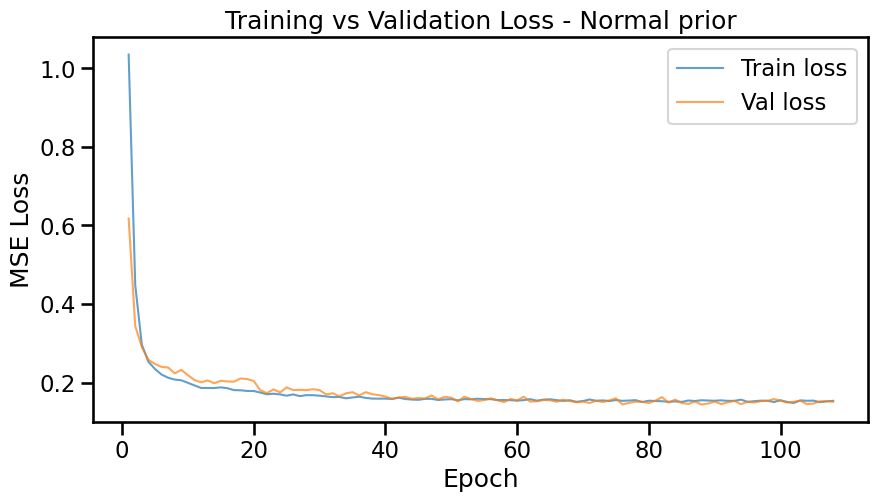

In [12]:
epochs = range(1, len(train_losses) + 1)


plt.figure(figsize=(10,5))

# Plot plain diffusion loop
plt.plot(epochs, train_losses, lw=1.5, alpha=0.7, label='Train loss')
plt.plot(epochs, val_losses,  lw=1.5, alpha=0.7,  label='Val loss')


plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Training vs Validation Loss - Normal prior')
plt.legend()

plt.show()

# Plotting the generated and real data

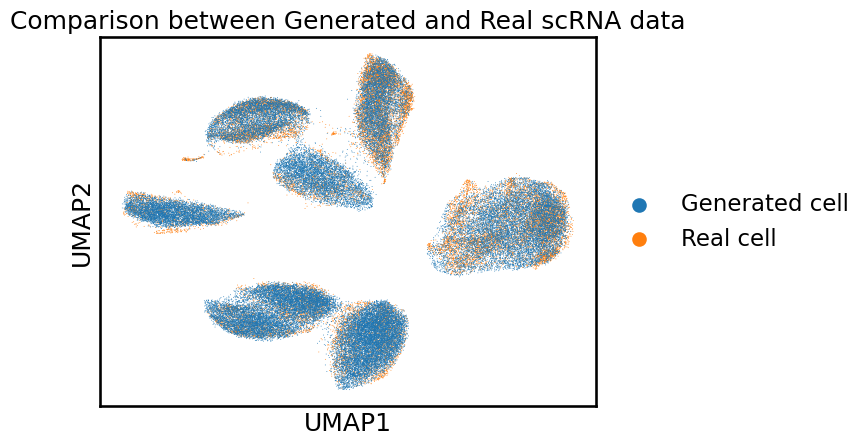

In [13]:
adata_gen = ad.AnnData(X=generated_data_normal,var=adata_sub.var.copy())
adata_gen.obs['cell_ontology_class'] = pd.Categorical.from_codes(
    generated_labels_normal,
    categories=adata_sub.obs['cell_ontology_class'].cat.categories
)
adata_gen.obs['source'] = 'Generated cell'
adata_sub.obs['source'] = 'Real cell'

adata_plot = ad.concat(
    [adata_sub,adata_gen],
    join='outer',
    label='batch',
    keys=['real','gen'])

sc.pp.pca(adata_plot, n_comps=50)
sc.pp.neighbors(adata_plot)
sc.tl.umap(adata_plot)

sc.pl.umap(
    adata_plot,
    color='source',
    title = 'Comparison between Generated and Real scRNA data',
    
)



In [14]:
metrics = evaluate_all(
    real_data    = adata_sub.X.toarray(),
    gen_data     = generated_data_normal,
    real_labels  = labels_encoded,
    gen_labels   = generated_labels_normal,
    adata_real   = adata_sub,
    adata_gen    = adata_gen
)

/opt/conda/lib/python3.11/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/opt/conda/lib/python3.11/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Spearman SCC: 0.0999
MMD:          0.0051
RF AUC:       1.0000
KNN Acc:      0.5585, KNN AUC: 0.7757


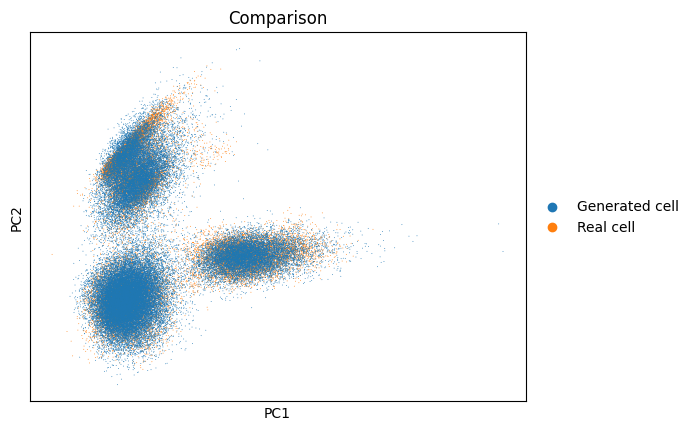

In [22]:
sc.pp.pca(adata_plot, n_comps=50)
sc.pl.pca(adata_plot, color='source', title='Comparison',show=True)

/tmp/ipykernel_932778/1685192005.py:18: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  combined_data = adata_plot[adata_plot.obs['cell_ontology_class'] == celltype].concatenate(other_cells)


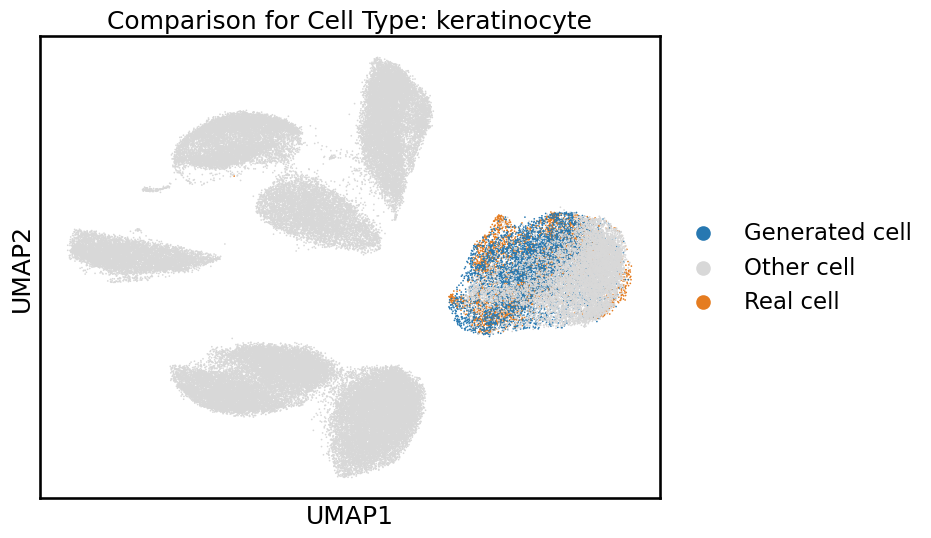

/tmp/ipykernel_932778/1685192005.py:18: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  combined_data = adata_plot[adata_plot.obs['cell_ontology_class'] == celltype].concatenate(other_cells)


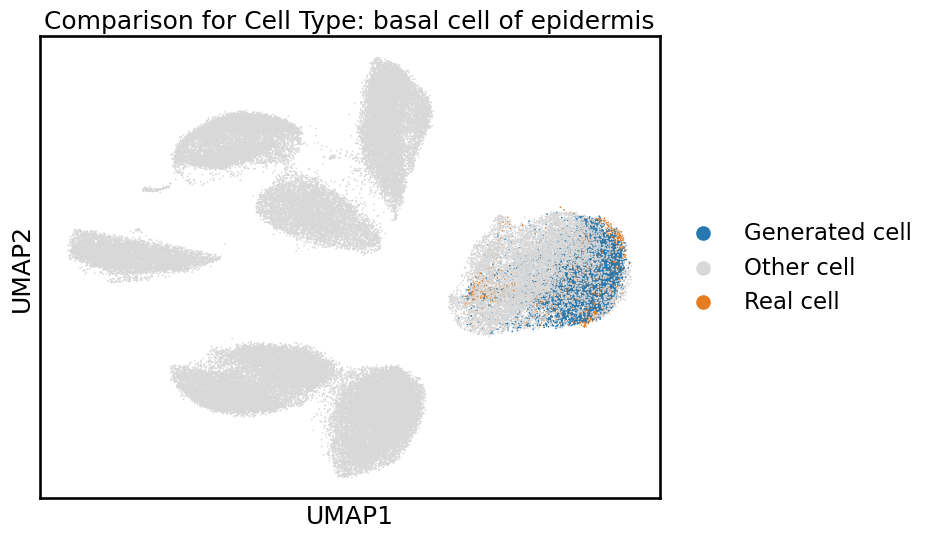

/tmp/ipykernel_932778/1685192005.py:18: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  combined_data = adata_plot[adata_plot.obs['cell_ontology_class'] == celltype].concatenate(other_cells)


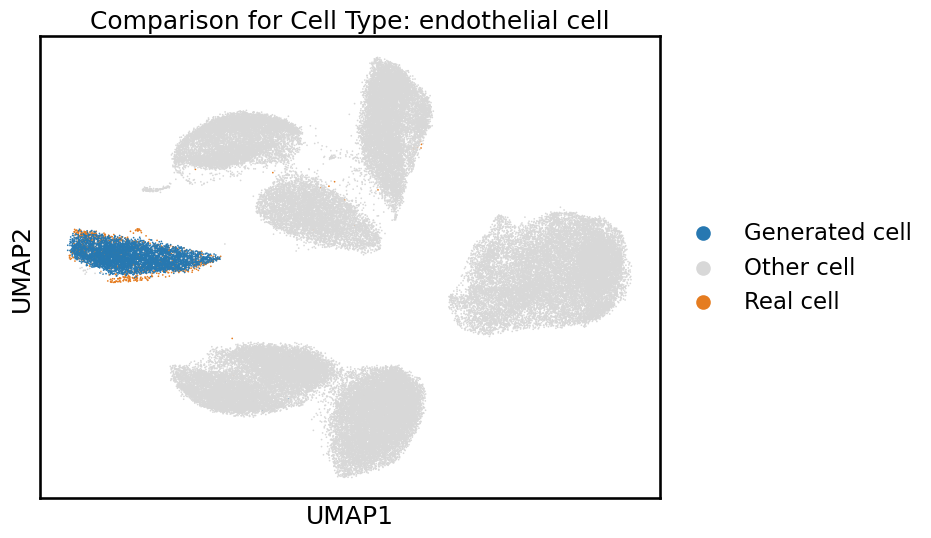

/tmp/ipykernel_932778/1685192005.py:18: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  combined_data = adata_plot[adata_plot.obs['cell_ontology_class'] == celltype].concatenate(other_cells)


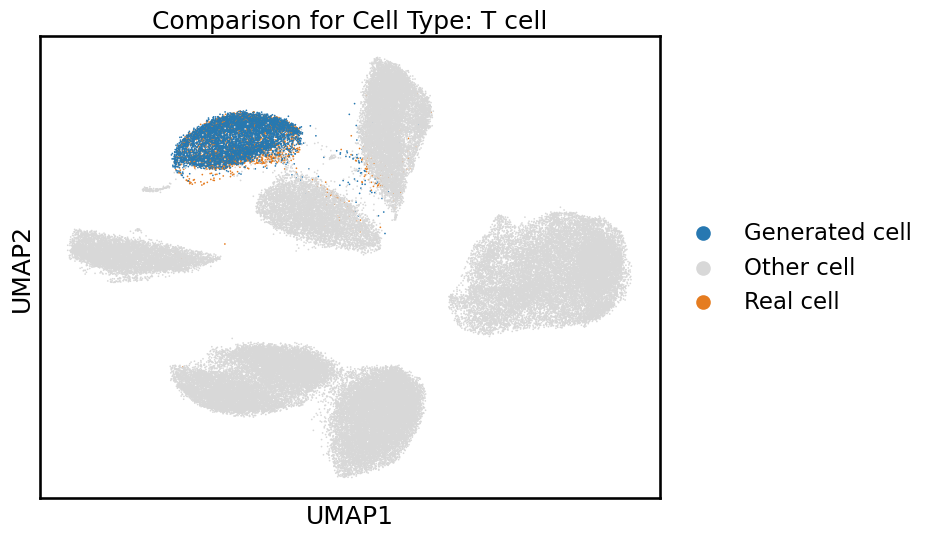

/tmp/ipykernel_932778/1685192005.py:18: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  combined_data = adata_plot[adata_plot.obs['cell_ontology_class'] == celltype].concatenate(other_cells)


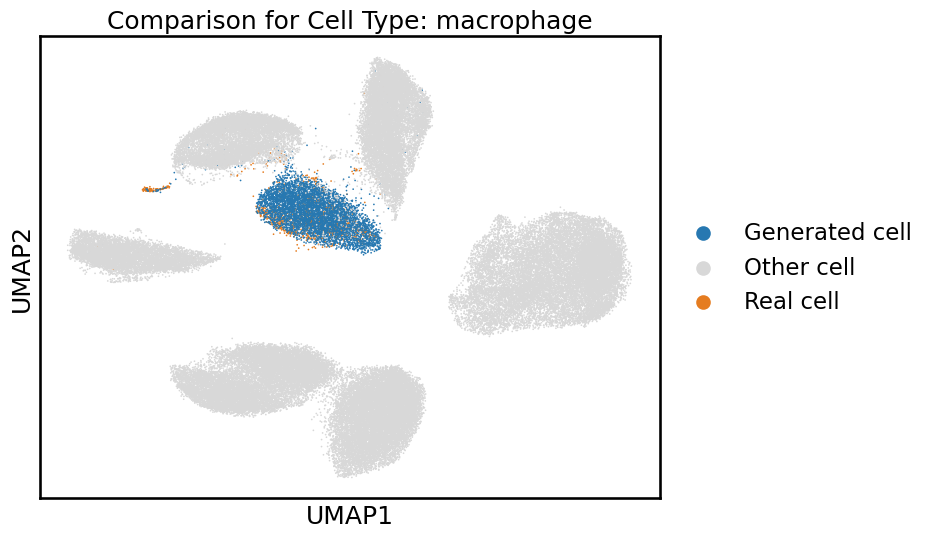

/tmp/ipykernel_932778/1685192005.py:18: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  combined_data = adata_plot[adata_plot.obs['cell_ontology_class'] == celltype].concatenate(other_cells)


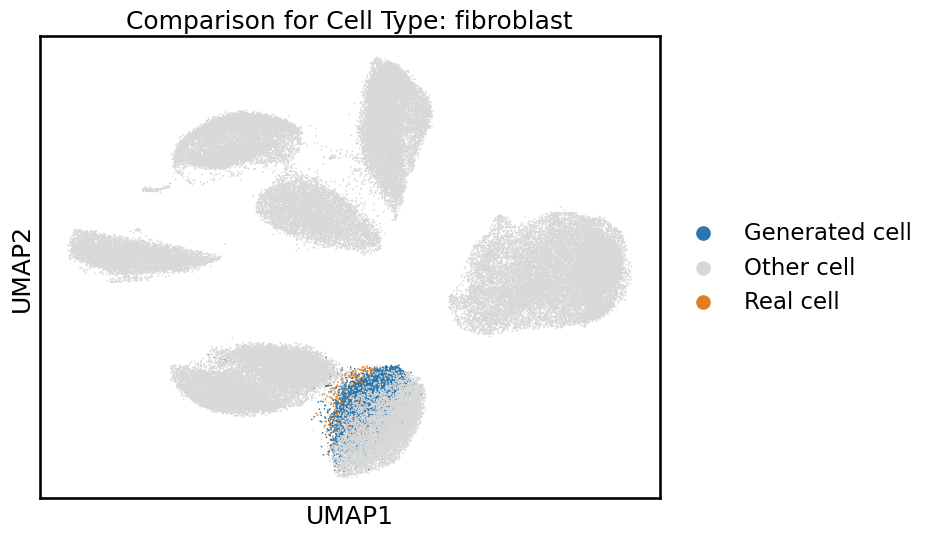

/tmp/ipykernel_932778/1685192005.py:18: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  combined_data = adata_plot[adata_plot.obs['cell_ontology_class'] == celltype].concatenate(other_cells)


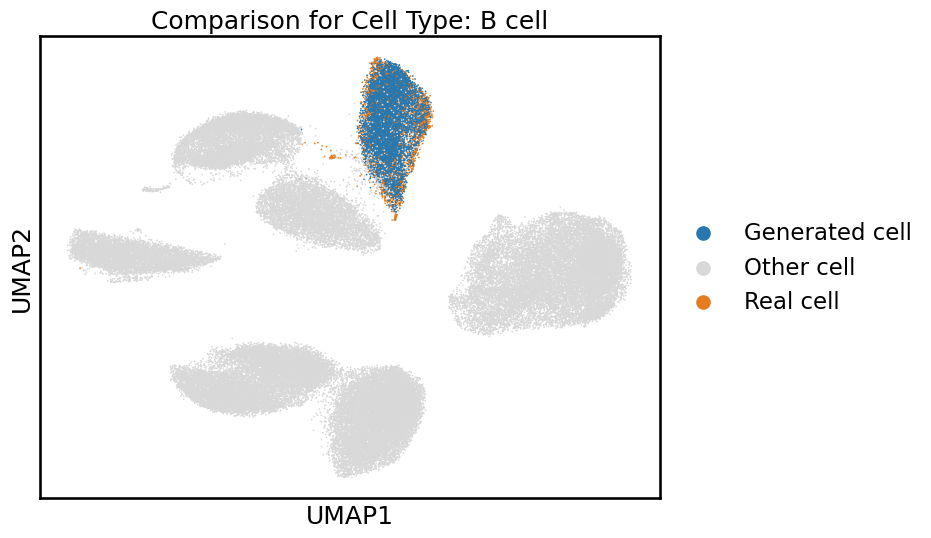

/tmp/ipykernel_932778/1685192005.py:18: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  combined_data = adata_plot[adata_plot.obs['cell_ontology_class'] == celltype].concatenate(other_cells)


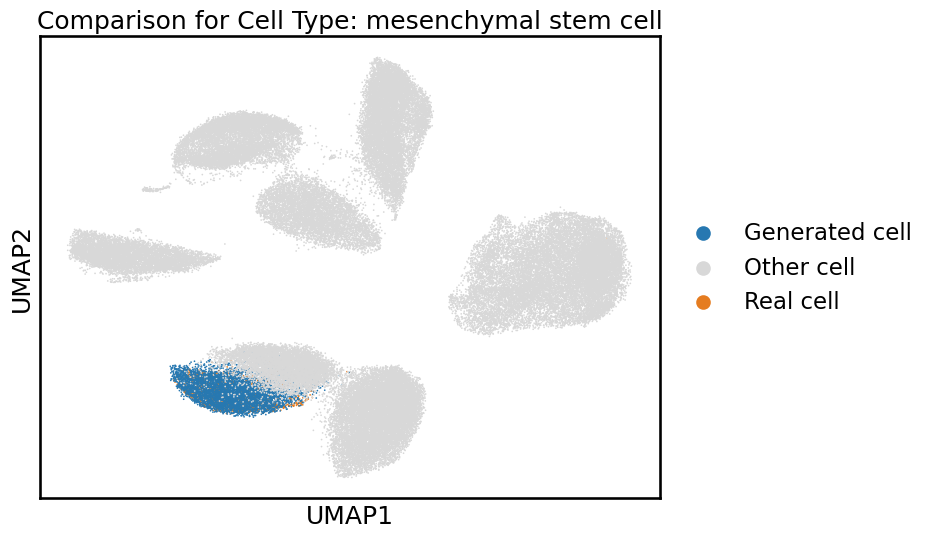

/tmp/ipykernel_932778/1685192005.py:18: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  combined_data = adata_plot[adata_plot.obs['cell_ontology_class'] == celltype].concatenate(other_cells)


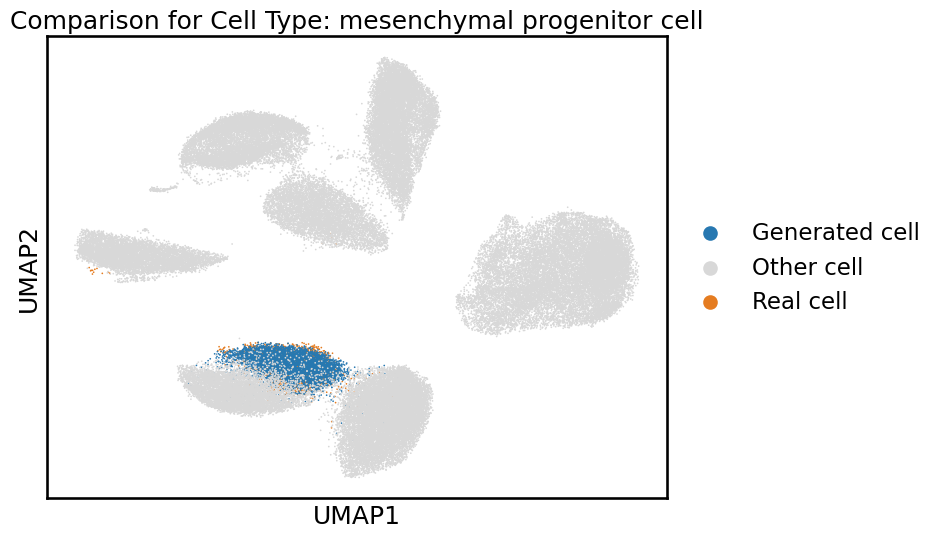

/tmp/ipykernel_932778/1685192005.py:18: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  combined_data = adata_plot[adata_plot.obs['cell_ontology_class'] == celltype].concatenate(other_cells)


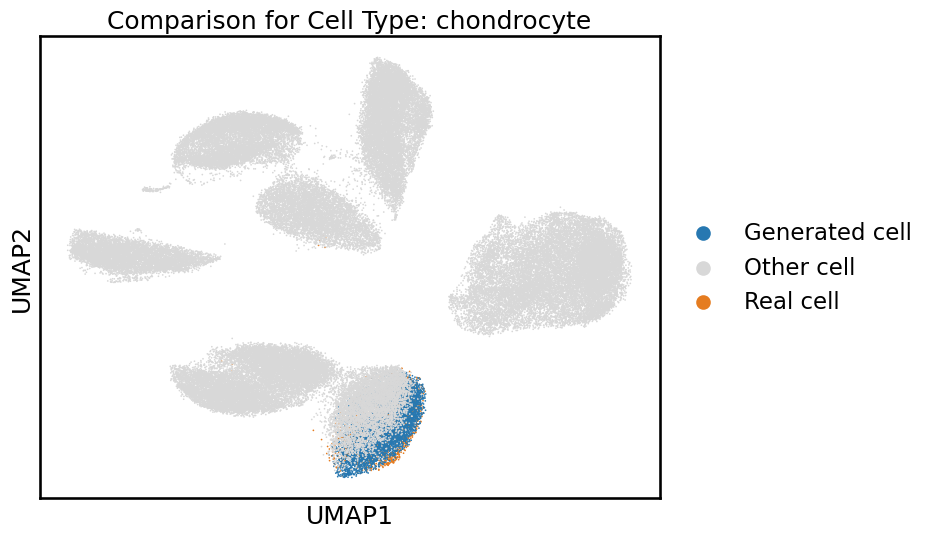

In [15]:
celltypes = adata_plot.obs['cell_ontology_class'].unique()
custom_palette = {
    'Real cell': '#e57c20',       
    'Generated cell': '#2778b1', 
    'Other cell': '#d8d8d8'     
}
for celltype in celltypes:
    fig, ax = plt.subplots(figsize=(8, 6))
    
    # Filter data for the current cell type (plot only real and generated of this type)
    subset = adata_plot[adata_plot.obs['cell_ontology_class'] == celltype]
    
    # Create a mask for other cell types (all data except current cell type)
    other_cells = adata_plot[adata_plot.obs['cell_ontology_class'] != celltype].copy()
    other_cells.obs['source'] = 'Other cell'  # Label other cells as 'Other cell'
    
    # Combine the current subset (real + generated) and 'Other' cells
    combined_data = adata_plot[adata_plot.obs['cell_ontology_class'] == celltype].concatenate(other_cells)
    
    # Plot UMAP for the current cell type, highlighting real and generated cells as well as other cells in black
    sc.pl.umap(combined_data, color='source', size=6, title=f'Comparison for Cell Type: {celltype}', ax=ax,palette=custom_palette)
    
    # Show the plot
    plt.show()

In [31]:
metrics = evaluate_all(
    real_data    = adata_sub.X.toarray(),
    gen_data     = generated_data_normal,
    real_labels  = labels_encoded,
    gen_labels   = generated_labels_normal,
    adata_real   = adata_sub,
    adata_gen    = adata_gen
)

/opt/conda/lib/python3.11/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/opt/conda/lib/python3.11/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Spearman SCC: 0.1049
MMD:          0.0066
RF AUC:       1.0000
KNN Acc:      0.6010, KNN AUC: 0.7959


# Training for log-normal distribution prior

In [16]:
##############################################
# 1. CONFIGURATION 
##############################################

class Config:
    # Data params
    batch_size = 320
    num_timesteps = 1000
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Model params
    input_dim = None  # set after loading data
    num_classes = None  # set after encoding labels
    hidden_dim = 512
    time_emb_dim = 128
    label_emb_dim = 128
    num_res_blocks = 6
    lr = 1e-3
    max_epochs = 1000

    # Early stopping
    patience = 20

    # Sampling params for log-normal prior
    log_prior_mu = 0
    log_prior_sigma = 1
    eps = 1e-6

    # Noise scheduler
    schedule_type = 'linear'

config = Config()


##############################################
# 2. UTILITIES
##############################################

def compute_pdist(X, Y=None, metric='euclidean'):
    if Y is None:
        Y = X
    return pairwise_distances(X, Y, metric=metric, n_jobs=-1)

def energy_distance(X, Y):
    XX = compute_pdist(X)
    YY = compute_pdist(Y)
    XY = compute_pdist(X, Y)
    return np.sqrt(2*np.mean(XY) - np.mean(XX) - np.mean(YY))

def classwise_energy_distance(real_data, generated_data, labels_encoded, generated_labels):
    energy_distances = []
    print("Energy Distance (per class):")
    for cls in np.unique(labels_encoded):
        real_cls_data = real_data[labels_encoded == cls]
        gen_cls_data = generated_data[generated_labels == cls]

        ed_cls = energy_distance(real_cls_data, gen_cls_data)
        energy_distances.append(ed_cls)

        class_name = le.inverse_transform([cls])[0]
        print(f"Class {class_name}: {ed_cls:.4f}")

    avg_ed = np.mean(energy_distances)
    return avg_ed


def mmd_rbf(X, Y, gamma=None):
    if gamma is None:
        gamma = 1.0 / X.shape[1]
    XX = rbf_kernel(X, X, gamma)
    YY = rbf_kernel(Y, Y, gamma)
    XY = rbf_kernel(X, Y, gamma)
    return XX.mean() + YY.mean() - 2 * XY.mean()

def classwise_mmd(real_data, generated_data, labels_encoded, generated_labels):
    mmd_scores = []
    print("MMD (per class):")
    for cls in np.unique(labels_encoded):
        real_cls_data = real_data[labels_encoded == cls]
        gen_cls_data = generated_data[generated_labels == cls]

        mmd_cls = mmd_rbf(real_cls_data, gen_cls_data)
        mmd_scores.append(mmd_cls)

        class_name = le.inverse_transform([cls])[0]
        print(f"Class {class_name}: {mmd_cls:.4f}")

    avg_mmd = np.mean(mmd_scores)
    return avg_mmd


##############################################
# 3. MODEL IMPLEMENTATION
##############################################
class SinusoidalPosEmb(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, t):
        device = t.device
        half_dim = self.dim // 2
        emb = torch.exp(torch.arange(half_dim, device=device) * -(torch.log(torch.tensor(10000.0)) / (half_dim - 1)))
        emb = t[:, None] * emb[None, :]
        emb = torch.cat([torch.sin(emb), torch.cos(emb)], dim=-1)
        return emb

class ResidualBlock(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.net = nn.Sequential(
            DenseBatchNorm(dim, dim*2,  activation='relu'),
            DenseBatchNorm(dim*2, dim)
        )
    def forward(self, x):
        return x + self.net(x)

class DenseBatchNorm(nn.Module):
    def __init__(self,in_units,out_units,activation=None):
        super().__init__()
        layers = [
            nn.Linear(in_units,out_units),
            nn.BatchNorm1d(out_units)
        ]
        if activation == 'relu':
            layers.append(nn.ReLU())
        self.dense_bn_act = nn.Sequential(*layers)

    def forward(self,x):
        return self.dense_bn_act(x)

class StableDiffusion(nn.Module):
    def __init__(self, input_dim, num_classes, hidden_dim=256, time_emb_dim=128, label_emb_dim=128, num_res_blocks=4):
        super().__init__()
        self.time_embedding = SinusoidalPosEmb(time_emb_dim)
        self.time_mlp = DenseBatchNorm(time_emb_dim, hidden_dim, activation='relu')
        self.label_embedding = nn.Embedding(num_classes, label_emb_dim)
        self.init_proj = DenseBatchNorm(input_dim + hidden_dim + label_emb_dim,
                                             hidden_dim, activation='relu')
        self.res_blocks = nn.ModuleList([ResidualBlock(hidden_dim) for _ in range(num_res_blocks)])
        self.final_layer = nn.Linear(hidden_dim, input_dim)

    def forward(self, x, t, labels):
        t_emb = self.time_embedding(t)
        t_emb = self.time_mlp(t_emb)
        label_emb = self.label_embedding(labels)
        h = torch.cat([x, t_emb, label_emb], dim=-1)
        h = self.init_proj(h)
        for block in self.res_blocks:
            h = block(h)
        return F.relu(self.final_layer(h))



class DiffusionProcessLogNormal:
    def __init__(self, input_dim, num_timesteps=1000, beta_start=1e-5, 
                 beta_end=0.02, schedule_type=config.schedule_type, 
                 mu=config.log_prior_mu, 
                 sigma=config.log_prior_sigma,clip_std=4.0):
        self.input_dim = input_dim
        self.mu = mu
        self.sigma = sigma
        self.num_timesteps = num_timesteps

        if schedule_type == 'linear':
            beta = torch.linspace(beta_start, beta_end, num_timesteps)
        elif schedule_type == 'cosine':
            beta = self._cosine_schedule(num_timesteps)
        else:
            raise ValueError("Unsupported schedule type. Use 'linear' or 'cosine'.")

        self.beta = beta
        self.alpha = 1 - beta
        self.alpha_bar = torch.cumprod(self.alpha, dim=0)
        self.lognormal = torch.distributions.LogNormal(self.mu, self.sigma)
        self.clip_std   = clip_std # to avoid too extreme value caused by log-normal

    def _cosine_schedule(self, num_timesteps, s=0.008):
        steps = torch.arange(num_timesteps + 1)/ num_timesteps
        alpha_bar = torch.cos((steps + s) / (1 + s) * torch.pi * 0.5) ** 2
        alpha_bar = alpha_bar / alpha_bar[0]
        alpha_bar[-1] =0.0
        beta = 1 - alpha_bar[1:] / alpha_bar[:-1]
        return torch.clamp(beta, 1e-4, 0.9999)

    def add_noise(self, x, t):
        # original data has been log-trans, need to convert back to linear scale
        sqrt_alpha_bar_t = torch.sqrt(self.alpha_bar[t])
        sqrt_one_minus_alpha_bar_t = torch.sqrt(1.0-self.alpha_bar[t])

        # sample log-normal noise
        noise = self.lognormal.sample(x.shape)
        # create noisy sample
        noisy_x = sqrt_alpha_bar_t*x+sqrt_one_minus_alpha_bar_t*noise

        return noisy_x, noise



class DiffusionDatasetLog(Dataset):
    def __init__(self, X, labels, diffusion, num_timesteps, eps=1e-6):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.labels = torch.tensor(labels, dtype=torch.long)
        self.diffusion = diffusion
        self.num_timesteps = num_timesteps

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        x_log = self.X[idx]
        t = torch.randint(0,self.diffusion.num_timesteps, ()).long()
        label = self.labels[idx]
        x_noisy, noise = self.diffusion.add_noise(x_log, t)
        return (x_noisy, t, label), noise

def prepare_dataset_log(X, labels, diffusion, batch_size, num_timesteps=1000):
    dataset = DiffusionDatasetLog(X, labels, diffusion, num_timesteps)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, pin_memory=True)
    return dataloader



##############################################
# 4. SAMPLING
##############################################


def sample_log_normal(model,diffusion,labels,num_samples,device='cuda'):
    model.eval()

    # start with pure log-normal noise
    x_t = diffusion.lognormal.sample((num_samples, config.input_dim)).squeeze(-1).to(device)
    labels = labels.to(device)

    for t in reversed(range(diffusion.num_timesteps)):
        # Create a tensor of the current timestep
        timestep = torch.full((num_samples,), t, dtype=torch.long, device=device)
        
        with torch.no_grad():
            # 1. Predict noise from the model
            pred_noise = model(x_t, timestep, labels)
            
            # 2. Predict x_0 (the original data) from x_t and pred_noise
            alpha_bar_t = diffusion.alpha_bar[t]
            pred_x0 = (x_t - torch.sqrt(1 - alpha_bar_t) * pred_noise) / torch.sqrt(alpha_bar_t)
            pred_x0 = pred_x0.clamp(min=0.0,max=10) # Enforce positivity, crucial for stability

            if t == 0:
                x_t = pred_x0 # Final sample is the predicted x_0
                break

            # 3. Use the predicted x_0 to step to x_{t-1}
            alpha_bar_prev = diffusion.alpha_bar[t-1]
            # Equation from DDIM paper (Eq. 12)
            x_t = torch.sqrt(alpha_bar_prev) * pred_x0 + \
                  torch.sqrt(1 - alpha_bar_prev) * pred_noise
            x_t = x_t.clamp(min=0.0,max=10)
                  
    return x_t.cpu().numpy()
##############################################
# 5. GENERATE SYNTHETIC DATA
##############################################


def generate_synthetic_data_log(model, diffusion, labels_encoded, num_samples, device):
    """Generates synthetic data for each class."""
    model.eval()
    unique_labels = np.unique(labels_encoded)
    all_generated_data = []
    all_generated_labels = []

    print("--- Generating Synthetic Data ---")
    for label in unique_labels:
        print(f"Generating for class {le.inverse_transform([label])[0]}...")
        label_tensor = torch.full((num_samples_per_class,), label, dtype=torch.long)
        
        samples = sample_log_normal(model,
            diffusion,
            label_tensor,
            num_samples,
            device=device)
        
        all_generated_data.append(samples)
        all_generated_labels.extend([label] * num_samples)

    generated_data = np.vstack(all_generated_data)
    generated_labels = np.array(all_generated_labels)
    return generated_data, generated_labels


##############################################
# 6. TRAINING LOOP
##############################################


def train_loop_log(config, model, train_loader, val_loader):
    
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4) 
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)
    best_val_loss = float('inf')
    trigger_times = 0

    train_losses = []
    val_losses = []

    for epoch in range(config.max_epochs):
        model.train()
        train_loss_accum = 0.0
        num_batches = 0

        for (x_noisy, t, label_batch), noise in train_loader:
            x_noisy = x_noisy.to(config.device)
            t = t.to(config.device)
            label_batch = label_batch.to(config.device)
            noise = noise.to(config.device)

        
            pred_noise = model(x_noisy, t, label_batch)

        
            loss = F.mse_loss(pred_noise, noise)
       

            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1)
            optimizer.step()

            train_loss_accum += loss.item()
            num_batches += 1

        avg_train_loss = train_loss_accum / num_batches
        train_losses.append(avg_train_loss)

        # Validation loop
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for (x_noisy, t, label_batch), noise in val_loader:
                x_noisy = x_noisy.to(config.device)
                t = t.to(config.device)
                label_batch = label_batch.to(config.device)
                noise = noise.to(config.device)

                pred_noise = model(x_noisy, t, label_batch)

                val_loss += F.mse_loss(pred_noise, noise).item()

        val_loss /= len(val_loader)
        val_losses.append(val_loss)

        print(f"Epoch {epoch+1}/{config.max_epochs} - Train Loss: {avg_train_loss:.6f} - Val Loss: {val_loss:.6f}")

        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            trigger_times = 0
        else:
            trigger_times += 1
            if trigger_times >= config.patience:
                print(f"Early stopping triggered at epoch {epoch+1}")
                break
        scheduler.step()
    return train_losses, val_losses

In [19]:
# Convert sparse matrix to dense
X = adata_sub.X
if scipy.sparse.issparse(X):
    X = X.toarray()

labels = adata_sub.obs['cell_ontology_class'].values
le = LabelEncoder()
labels_encoded = le.fit_transform(labels)

# parameter for config
config.input_dim = X.shape[1]
config.num_classes = len(np.unique(labels_encoded))

# Split data
X_train, X_val, y_train, y_val = train_test_split(
    X, labels_encoded,
    test_size=0.2,
    random_state=42,
    stratify=labels_encoded
)

In [20]:
if __name__ == "__main__":
    # Initialize diffusion process (normal prior)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    diffusion = DiffusionProcessLogNormal(config.input_dim,
                                 num_timesteps=config.num_timesteps,
                                 schedule_type='cosine')
    train_loader = prepare_dataset_log(X_train, y_train, diffusion, batch_size=config.batch_size)
    val_loader   = prepare_dataset_log(X_val,   y_val,   diffusion, batch_size=config.batch_size)

    # Initialize model
    model = StableDiffusion(
        input_dim=config.input_dim,
        num_classes=config.num_classes,
        hidden_dim=config.hidden_dim,
        time_emb_dim=config.time_emb_dim,
        label_emb_dim=config.label_emb_dim,
        num_res_blocks=config.num_res_blocks
    ).to(config.device)

    # Train with normal prior data preparation
    train_losses_log, val_losses_log = train_loop_log(
    config=config,
    model=model,
    train_loader=train_loader,
    val_loader=val_loader)

    # Save the trained model weights
    torch.save(model.state_dict(), './weight/stable_diffusion_log_prior.pth')
    print("Model trained and saved with log prior.")

    # Load your trained model weights (normal prior model)
    model.load_state_dict(torch.load('./weight/stable_diffusion_log_prior.pth', map_location=device))
    model.eval()

    # Generate synthetic data per class
    num_samples_per_class = 5000
    generated_data_log, generated_labels_log = generate_synthetic_data_log(model, diffusion, labels_encoded, num_samples_per_class,device)



Epoch 1/1000 - Train Loss: 4.280302 - Val Loss: 2.233164
Epoch 2/1000 - Train Loss: 1.620870 - Val Loss: 1.334383
Epoch 3/1000 - Train Loss: 1.169031 - Val Loss: 1.044699
Epoch 4/1000 - Train Loss: 0.967166 - Val Loss: 0.893353
Epoch 5/1000 - Train Loss: 0.856204 - Val Loss: 0.810779
Epoch 6/1000 - Train Loss: 0.790488 - Val Loss: 0.762736
Epoch 7/1000 - Train Loss: 0.744298 - Val Loss: 0.723693
Epoch 8/1000 - Train Loss: 0.708072 - Val Loss: 0.688511
Epoch 9/1000 - Train Loss: 0.681590 - Val Loss: 0.673491
Epoch 10/1000 - Train Loss: 0.665083 - Val Loss: 0.646680
Epoch 11/1000 - Train Loss: 0.634951 - Val Loss: 0.616901
Epoch 12/1000 - Train Loss: 0.630315 - Val Loss: 0.613848
Epoch 13/1000 - Train Loss: 0.617305 - Val Loss: 0.604751
Epoch 14/1000 - Train Loss: 0.618215 - Val Loss: 0.596949
Epoch 15/1000 - Train Loss: 0.605297 - Val Loss: 0.590539
Epoch 16/1000 - Train Loss: 0.601689 - Val Loss: 0.586649
Epoch 17/1000 - Train Loss: 0.593647 - Val Loss: 0.585081
Epoch 18/1000 - Train L

/tmp/ipykernel_932778/98121436.py:33: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('./weight/stable_diffusion_log_prior.pth', map_location=

In [48]:
generated_data_log

array([[3.046962 , 3.4728534, 2.616728 , ..., 8.438463 , 7.3549724,
        8.57655  ],
       [2.7224736, 3.0321693, 4.16831  , ..., 7.759614 , 8.610026 ,
        8.668995 ],
       [2.412893 , 3.1854744, 3.4693146, ..., 7.37277  , 8.573532 ,
        8.918072 ],
       ...,
       [1.74106  , 2.9644988, 3.702797 , ..., 7.5339117, 6.8377013,
        8.764177 ],
       [3.406335 , 1.6068574, 4.91584  , ..., 7.3220544, 7.0627437,
        8.031308 ],
       [2.3817341, 3.0654948, 4.022332 , ..., 8.254795 , 7.7110586,
        7.5434628]], dtype=float32)

In [21]:
classwise_energy_distance(real_data=X, generated_data=generated_data_log, labels_encoded=labels_encoded, generated_labels=generated_labels_log)

Energy Distance (per class):
Class B cell: 7.8228
Class T cell: 7.7195
Class basal cell of epidermis: 6.6978
Class chondrocyte: 7.6356
Class endothelial cell: 7.6895
Class fibroblast: 7.6557
Class keratinocyte: 6.4398
Class macrophage: 7.0397
Class mesenchymal progenitor cell: 7.6215
Class mesenchymal stem cell: 7.4517


7.377359449318028

In [50]:
classwise_mmd(real_data=X, generated_data=generated_data_log, labels_encoded=labels_encoded, generated_labels=generated_labels_log)

MMD (per class):
Class B cell: 0.8837
Class T cell: 0.8904
Class basal cell of epidermis: 0.7218
Class chondrocyte: 0.7566
Class endothelial cell: 0.6493
Class fibroblast: 0.7307
Class keratinocyte: 0.5926
Class macrophage: 0.4944
Class mesenchymal progenitor cell: 0.7823
Class mesenchymal stem cell: 0.6843


0.7186123387112444

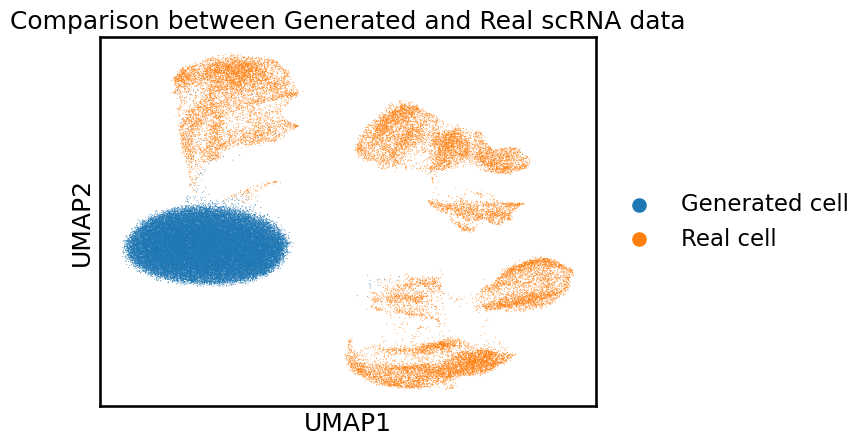

In [22]:
adata_gen_log = ad.AnnData(X=generated_data_log,var=adata_sub.var.copy())
adata_gen_log.obs['cell_ontology_class'] = pd.Categorical.from_codes(
    generated_labels_log,
    categories=adata_sub.obs['cell_ontology_class'].cat.categories
)
adata_gen_log.obs['source'] = 'Generated cell'
adata_sub.obs['source'] = 'Real cell'

adata_plot_log = ad.concat(
    [adata_sub,adata_gen_log],
    join='outer',
    label='batch',
    keys=['real','gen'])

sc.pp.pca(adata_plot_log, n_comps=50)
sc.pp.neighbors(adata_plot_log)
sc.tl.umap(adata_plot_log)

sc.pl.umap(
    adata_plot_log,
    color='source',
    title = 'Comparison between Generated and Real scRNA data',
    
)




In [23]:
metrics = evaluate_all(
    real_data    = adata_sub.X.toarray(),
    gen_data     = generated_data_log,
    real_labels  = labels_encoded,
    gen_labels   = generated_labels_log,
    adata_real   = adata_sub,
    adata_gen    = adata_gen_log
)

/opt/conda/lib/python3.11/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/opt/conda/lib/python3.11/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Spearman SCC: 0.0657
MMD:          0.4653
RF AUC:       1.0000
KNN Acc:      0.9012, KNN AUC: 0.9576


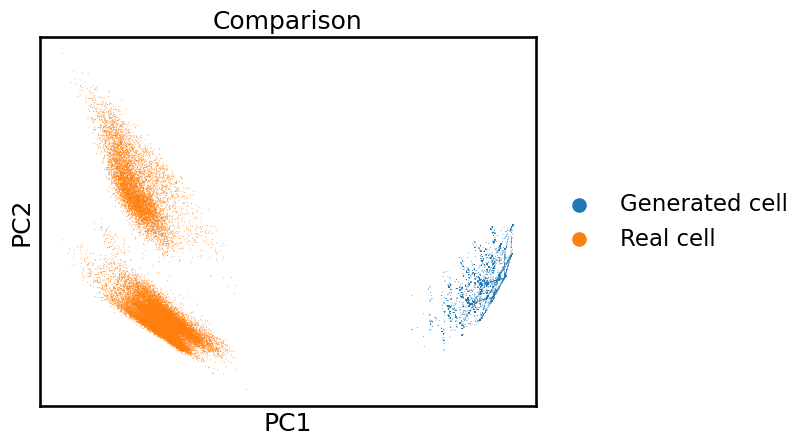

In [36]:
sc.pp.pca(adata_plot_log, n_comps=50)
sc.pl.pca(adata_plot_log, color='source', title='Comparison',show=True)

/tmp/ipykernel_932778/3795633488.py:18: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  combined_data = adata_plot_log[adata_plot_log.obs['cell_ontology_class'] == celltype].concatenate(other_cells)


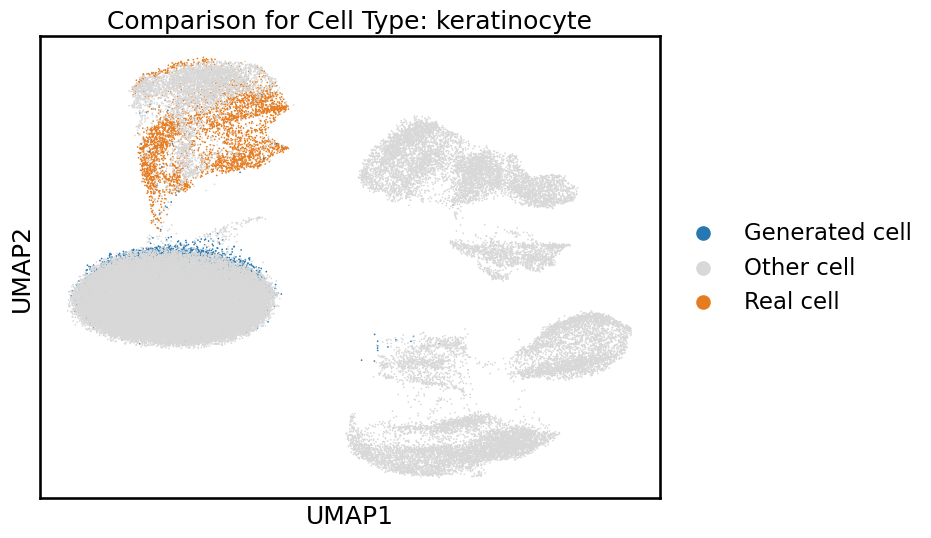

/tmp/ipykernel_932778/3795633488.py:18: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  combined_data = adata_plot_log[adata_plot_log.obs['cell_ontology_class'] == celltype].concatenate(other_cells)


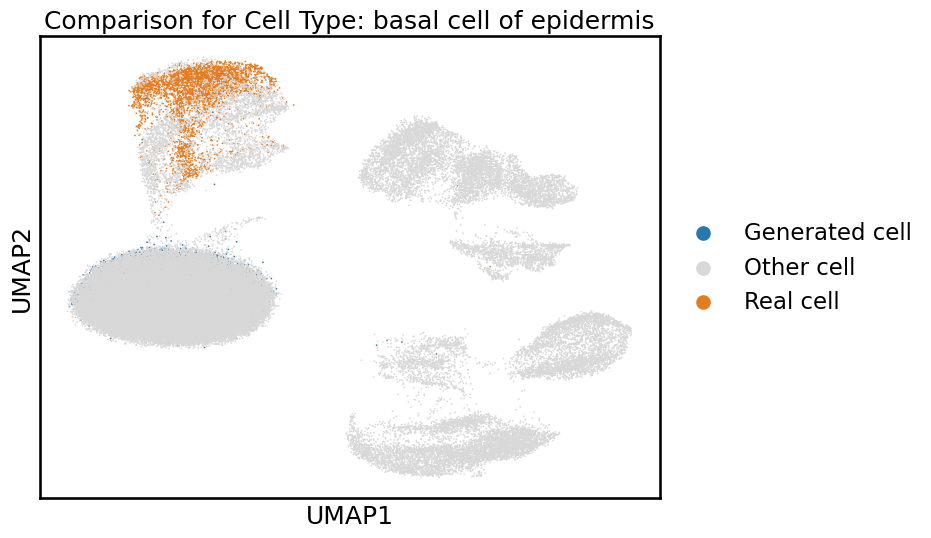

/tmp/ipykernel_932778/3795633488.py:18: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  combined_data = adata_plot_log[adata_plot_log.obs['cell_ontology_class'] == celltype].concatenate(other_cells)


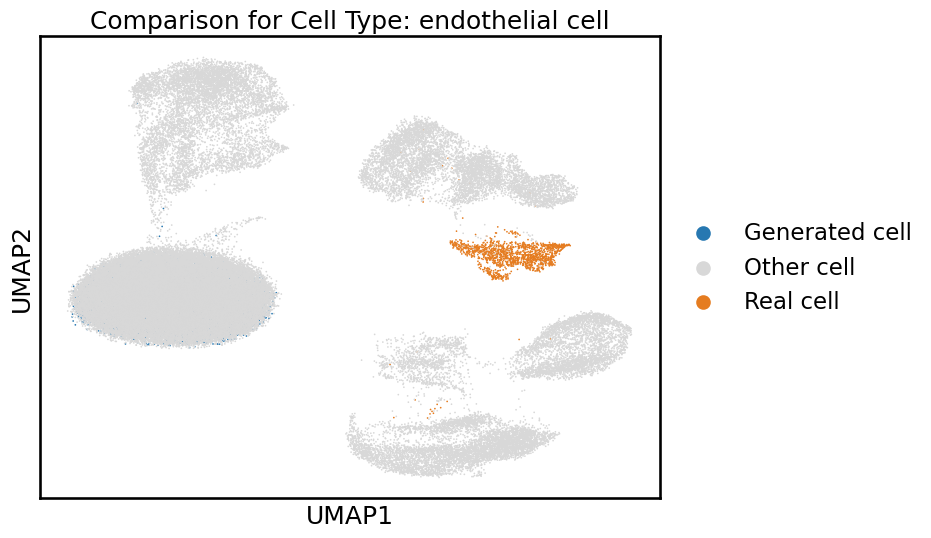

/tmp/ipykernel_932778/3795633488.py:18: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  combined_data = adata_plot_log[adata_plot_log.obs['cell_ontology_class'] == celltype].concatenate(other_cells)


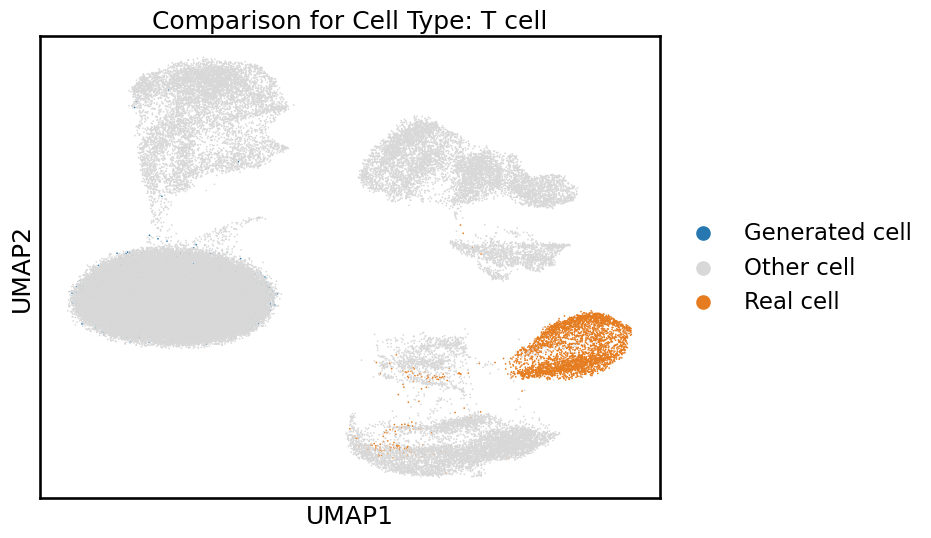

/tmp/ipykernel_932778/3795633488.py:18: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  combined_data = adata_plot_log[adata_plot_log.obs['cell_ontology_class'] == celltype].concatenate(other_cells)


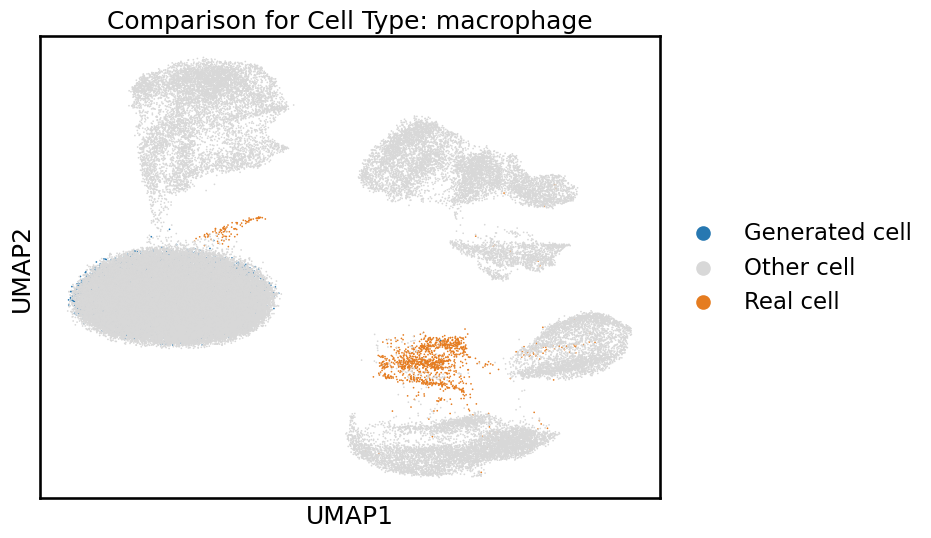

/tmp/ipykernel_932778/3795633488.py:18: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  combined_data = adata_plot_log[adata_plot_log.obs['cell_ontology_class'] == celltype].concatenate(other_cells)


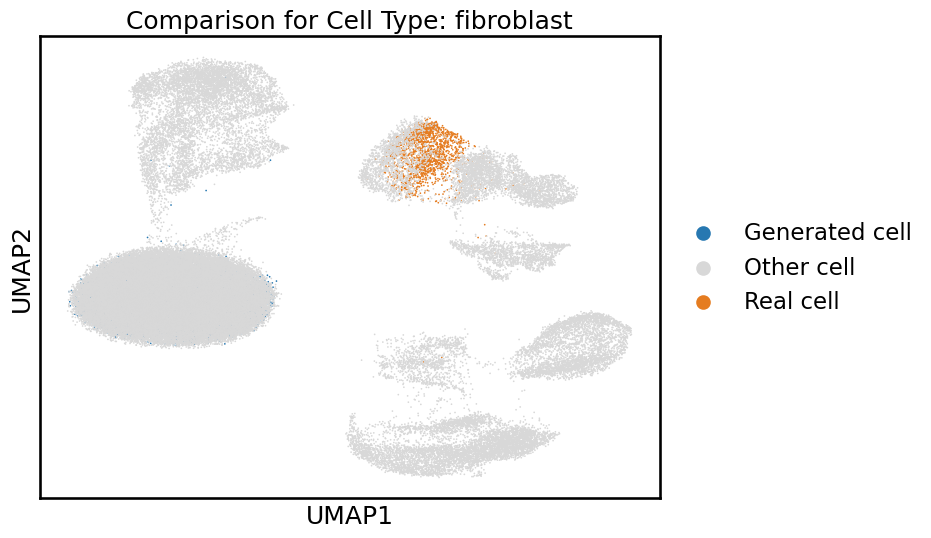

/tmp/ipykernel_932778/3795633488.py:18: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  combined_data = adata_plot_log[adata_plot_log.obs['cell_ontology_class'] == celltype].concatenate(other_cells)


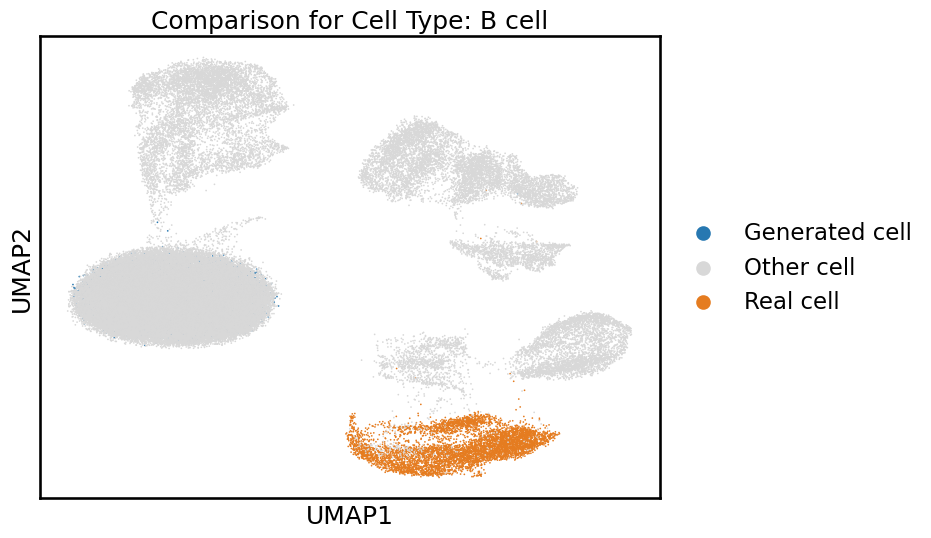

/tmp/ipykernel_932778/3795633488.py:18: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  combined_data = adata_plot_log[adata_plot_log.obs['cell_ontology_class'] == celltype].concatenate(other_cells)


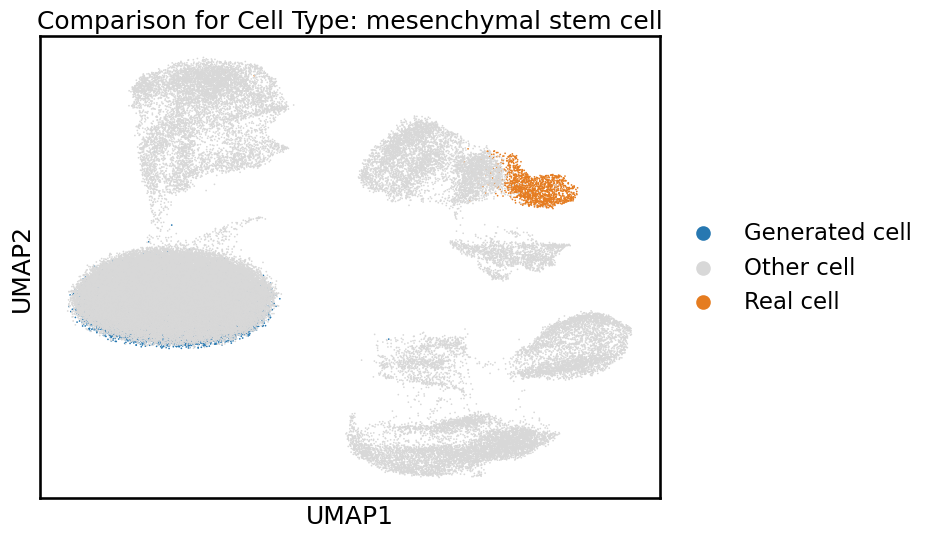

/tmp/ipykernel_932778/3795633488.py:18: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  combined_data = adata_plot_log[adata_plot_log.obs['cell_ontology_class'] == celltype].concatenate(other_cells)


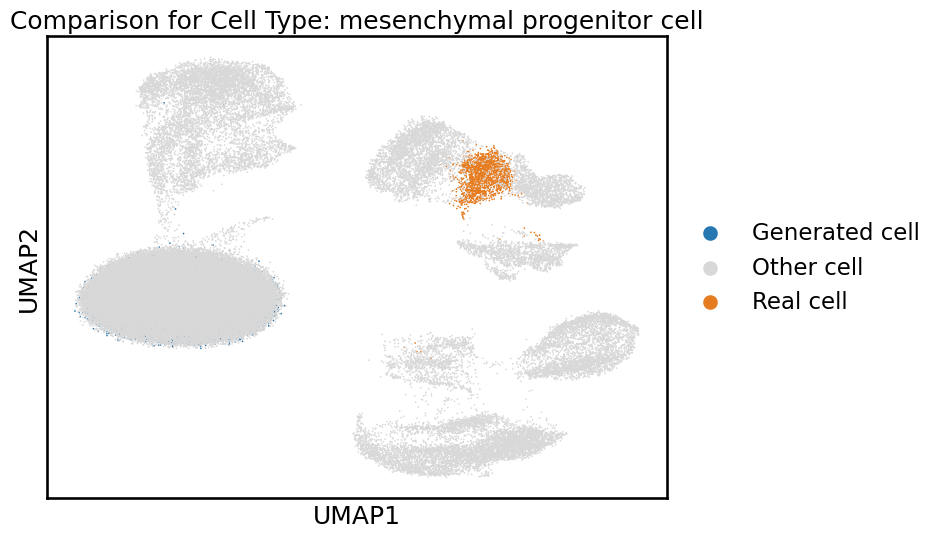

/tmp/ipykernel_932778/3795633488.py:18: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  combined_data = adata_plot_log[adata_plot_log.obs['cell_ontology_class'] == celltype].concatenate(other_cells)


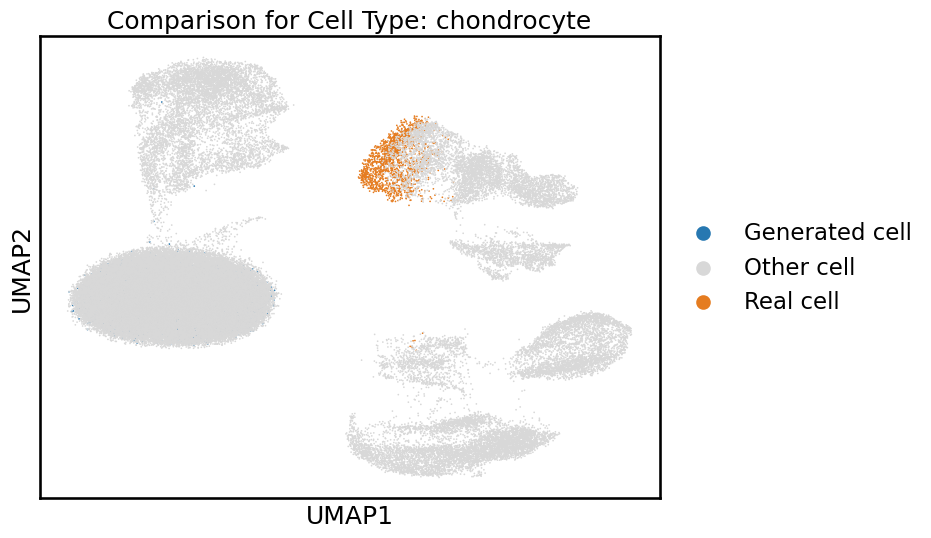

In [25]:
celltypes = adata_plot_log.obs['cell_ontology_class'].unique()
custom_palette = {
    'Real cell': '#e57c20',       
    'Generated cell': '#2778b1', 
    'Other cell': '#d8d8d8'     
}
for celltype in celltypes:
    fig, ax = plt.subplots(figsize=(8, 6))
    
    # Filter data for the current cell type (plot only real and generated of this type)
    subset = adata_plot_log[adata_plot_log.obs['cell_ontology_class'] == celltype]
    
    # Create a mask for other cell types (all data except current cell type)
    other_cells = adata_plot_log[adata_plot_log.obs['cell_ontology_class'] != celltype].copy()
    other_cells.obs['source'] = 'Other cell'  # Label other cells as 'Other cell'
    
    # Combine the current subset (real + generated) and 'Other' cells
    combined_data = adata_plot_log[adata_plot_log.obs['cell_ontology_class'] == celltype].concatenate(other_cells)
    
    # Plot UMAP for the current cell type, highlighting real and generated cells as well as other cells in black
    sc.pl.umap(combined_data, color='source', size=6, title=f'Comparison for Cell Type: {celltype}', ax=ax,palette=custom_palette)
    
    # Show the plot
    plt.show()

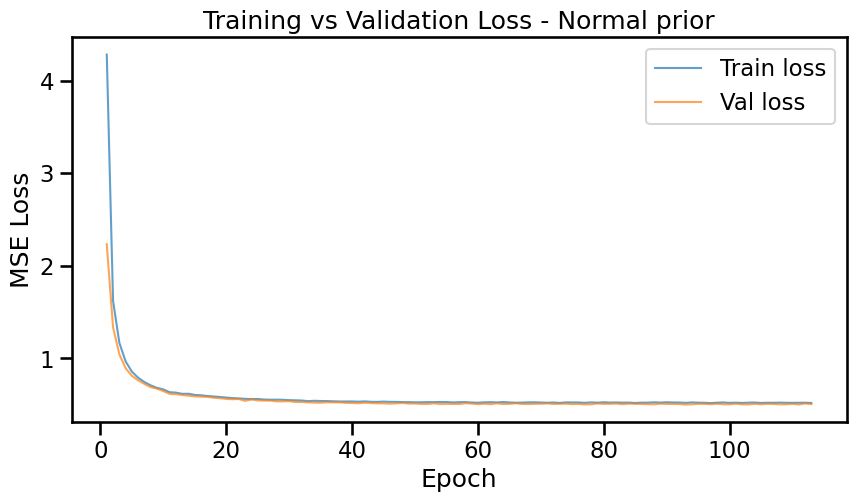

In [24]:
epochs = range(1, len(train_losses_log) + 1)


plt.figure(figsize=(10,5))

# Plot plain diffusion loop
plt.plot(epochs, train_losses_log, lw=1.5, alpha=0.7, label='Train loss')
plt.plot(epochs, val_losses_log,  lw=1.5, alpha=0.7,  label='Val loss')


plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Training vs Validation Loss - Normal prior')
plt.legend()

plt.show()

# Plot the noise process

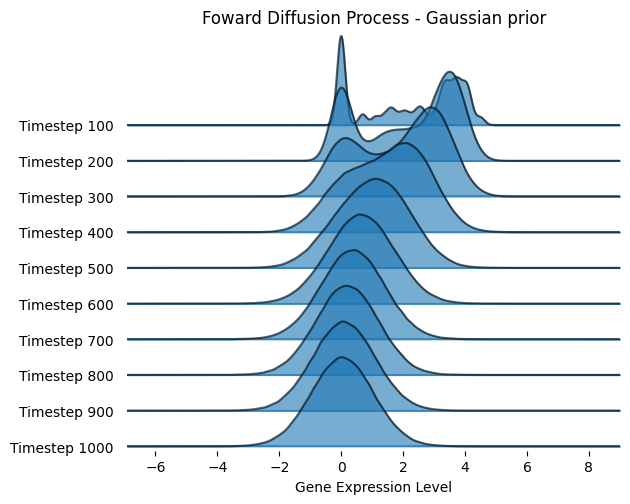

In [20]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from joypy import joyplot

X = adata_sub.X
if scipy.sparse.issparse(X):
    X = X.toarray()
x0 = torch.tensor(X[0], dtype=torch.float32)

diff = DiffusionProcess(input_dim=x0.shape[0])
n_draws   = 2000

all_xt = []
for t in range(0,config.num_timesteps,100):
    xt_samples = []
    t_tensor   = torch.tensor([t], dtype=torch.long)
    for _ in range(n_draws):
        # add_noise works on a single sample here
        x_t, _ = diff.add_noise(x0, t_tensor)
        xt_samples.append(x_t.numpy())
    all_xt.append(np.concatenate(xt_samples))  # flatten to 1D

# 5) joyplot them exactly like before
fig, axes = joyplot(
    all_xt,
    labels=[f"Timestep {(t+1)*100}" for t in range(len(all_xt))],  # Labels for each timestep
    grid=False,
    ylim='auto',
    alpha=0.6
)

# Customize the plot with title and labels
plt.title('Foward Diffusion Process - Gaussian prior')
plt.xlabel('Gene Expression Level')
plt.ylabel('Density')
plt.show()




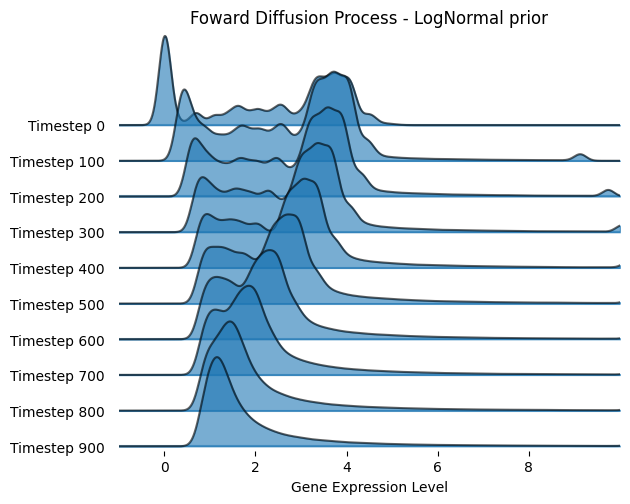

In [16]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from joypy import joyplot

X = adata_sub.X
if scipy.sparse.issparse(X):
    X = X.toarray()
x0 = torch.tensor(X[0], dtype=torch.float32)

diff = DiffusionProcessLogNormal(input_dim=x0.shape[0])
n_draws   = 2000

all_xt = []
for t in range(0,config.num_timesteps,100):
    xt_samples = []
    t_tensor   = torch.tensor([t], dtype=torch.long)
    for _ in range(n_draws):
        # add_noise works on a single sample here
        x_t, _ = diff.add_noise(x0, t_tensor)
        xt_samples.append(x_t.numpy())
    all_xt.append(np.concatenate(xt_samples))  # flatten to 1D

# 5) joyplot them exactly like before
fig, axes = joyplot(
    all_xt,
    labels=[f"Timestep {(t)*100}" for t in range(len(all_xt))],  # Labels for each timestep
    grid=False,
    ylim='auto',
    x_range=(-1,10),
    alpha=0.6
)

# Customize the plot with title and labels
plt.title('Foward Diffusion Process - LogNormal prior')
plt.xlabel('Gene Expression Level')
plt.ylabel('Density')
plt.show()




# VAE and GMM for benchmark

In [26]:
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.mixture import GaussianMixture

##############################################
# 1. Variational Autoencoder (VAE)
##############################################

class VAE(nn.Module):
    def __init__(self, input_dim, num_classes, latent_dim=128, hidden_dim=64):
        super().__init__()
        self.label_emb = nn.Embedding(num_classes, hidden_dim)
        # Encoder: input concatenated with label embedding
        self.encoder = nn.Sequential(
            nn.Linear(input_dim + hidden_dim, hidden_dim),
            nn.ReLU(),
        )
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim)
        # Decoder: latent + label embedding
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim + hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim),
        )

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x, y):
        y_emb = self.label_emb(y)
        h = torch.cat([x, y_emb], dim=1)
        h = self.encoder(h)
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        z = self.reparameterize(mu, logvar)
        zcat = torch.cat([z, y_emb], dim=1)
        x_recon = self.decoder(zcat)
        return x_recon, mu, logvar


# Loss for VAE
def vae_loss(x_recon, x, mu, logvar):
    recon_loss = nn.functional.mse_loss(x_recon, x, reduction='mean')
    # KL divergence
    kld = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + kld

# Training loop for VAE
def train_vae(model, X, y, epochs=1000, lr=1e-3, batch_size=320):
    device = next(model.parameters()).device
    dataset = TensorDataset(X.to(device), y.to(device))
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    model.train()
    for epoch in range(epochs):
        total=0
        for xb, yb in loader:
            recon, mu, logvar = model(xb, yb)
            loss = vae_loss(recon, xb, mu, logvar)
            optimizer.zero_grad(); loss.backward(); optimizer.step()
            total += loss.item()
        print(f"VAE epoch {epoch+1}, loss {total/len(X):.4f}")
    return model

# Generate data from VAE
def generate_vae(model, num_samples,device='cuda'):
    model.eval()
    C = model.label_emb.num_embeddings
    D = model.decoder[-1].out_features  # final output dim

    all_samples = []
    all_labels  = []

    with torch.no_grad():
        for cls in range(C):
            # build a label‐tensor of size [num_per_class]
            y_cls = torch.full(
                (num_samples,), 
                cls, 
                dtype=torch.long, 
                device=device
            )
            # embed and sample
            y_emb = model.label_emb(y_cls)
            z     = torch.randn(num_samples, model.fc_mu.out_features, device=device)
            zin   = torch.cat([z, y_emb], dim=1)
            Xc    = model.decoder(zin)               # torch.Tensor [num_per_class, D]
            all_samples.append(Xc.cpu().numpy())
            all_labels.extend([cls] * num_samples)

    X_gen = np.vstack(all_samples)               # (C*num_per_class, D)
    y_gen = np.array(all_labels, dtype=int)      # (C*num_per_class,)
    return X_gen, y_gen

    
##############################################
# 2. Gaussian Mixture Model (GMM)
##############################################

def train_gmm(X, labels, n_components=5, covariance_type='full'):
    gmms = {}
    for cls in np.unique(labels):
        Xc = X[labels==cls]
        gmm = GaussianMixture(n_components=n_components,
                              covariance_type=covariance_type,
                              random_state=0)
        gmm.fit(Xc)
        gmms[cls] = gmm
    return gmms


# Generate from fitted GMM
def generate_gmm(gmms, labels, num_per_class):
    all_samples, all_labels = [], []
    for cls, gmm in gmms.items():
        samp, _ = gmm.sample(num_per_class)
        all_samples.append(samp)
        all_labels.extend([cls]*num_per_class)
    return np.vstack(all_samples), np.array(all_labels)

In [35]:
# Convert sparse matrix to dense
X = adata_sub.X
if scipy.sparse.issparse(X):
    X = X.toarray()

labels = adata_sub.obs['cell_ontology_class'].values
le = LabelEncoder()
labels_encoded = le.fit_transform(labels)

# parameter for config
config.input_dim = X.shape[1]
config.num_classes = len(np.unique(labels_encoded))

# Split data
X_train, X_val, y_train, y_val = train_test_split(
    X, labels_encoded,
    test_size=0.2,
    random_state=42,
    stratify=labels_encoded
)

In [34]:
from sklearn.metrics import mean_squared_error
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
Xt_train = torch.tensor(X_train, dtype=torch.float32, device=device)
yt_train = torch.tensor(y_train, dtype=torch.long, device=device)
Xt_val   = torch.tensor(X_val,   dtype=torch.float32, device=device)
yt_val   = torch.tensor(y_val,   dtype=torch.long, device=device)

# 3) Train your CVAE on the train split
vae = VAE(input_dim=X_train.shape[1], num_classes=config.num_classes).to(device)
train_vae(vae, Xt_train, yt_train, epochs=100, lr=1e-3, batch_size=config.batch_size)

# 4) Evaluate VAE reconstruction error on the *val* split
vae.eval()
with torch.no_grad():
    Xval_recon, mu_val, logvar_val = vae(Xt_val, yt_val)
mse_val = mean_squared_error(Xt_val.cpu().numpy(), Xval_recon.cpu().numpy())
print(f"VAE Val Reconstruction MSE: {mse_val:.4f}")

# 5) Generate *new* samples for each val label and compute downstream metrics
num_per_class = 1000
y_sample = torch.cat([
    torch.full((num_per_class,), cls, dtype=torch.long, device=device)
    for cls in np.unique(y_val)
])
X_vae_gen, labels_vae = generate_vae(
    model=vae, 
    num_samples=1000, 
    device=device
)

# 6) Train conditional GMMs on the *train* split
gmms = train_gmm(X_train, y_train, n_components=10)

# 7) Evaluate GMM log-likelihood on the *val* split
log_liks = []
for cls in np.unique(y_val):
    mask = (y_val == cls)
    log_liks.append(gmms[cls].score(X_val[mask]).mean())
print(f"GMM Val Avg Log-Likelihood: {np.mean(log_liks):.4f}")

# 8) Generate GMM samples for each val class
X_gmm_gen, labels_gmm = generate_gmm(gmms, y_val, num_per_class)


VAE epoch 1, loss 1.4920
VAE epoch 2, loss 0.1128
VAE epoch 3, loss 0.0276
VAE epoch 4, loss 0.0073
VAE epoch 5, loss 0.0027
VAE epoch 6, loss 0.0017
VAE epoch 7, loss 0.0015
VAE epoch 8, loss 0.0014
VAE epoch 9, loss 0.0014
VAE epoch 10, loss 0.0014
VAE epoch 11, loss 0.0014
VAE epoch 12, loss 0.0014
VAE epoch 13, loss 0.0014
VAE epoch 14, loss 0.0014
VAE epoch 15, loss 0.0014
VAE epoch 16, loss 0.0014
VAE epoch 17, loss 0.0014
VAE epoch 18, loss 0.0014
VAE epoch 19, loss 0.0014
VAE epoch 20, loss 0.0013
VAE epoch 21, loss 0.0013
VAE epoch 22, loss 0.0013
VAE epoch 23, loss 0.0013
VAE epoch 24, loss 0.0013
VAE epoch 25, loss 0.0013
VAE epoch 26, loss 0.0013
VAE epoch 27, loss 0.0013
VAE epoch 28, loss 0.0013
VAE epoch 29, loss 0.0013
VAE epoch 30, loss 0.0013
VAE epoch 31, loss 0.0013
VAE epoch 32, loss 0.0013
VAE epoch 33, loss 0.0013
VAE epoch 34, loss 0.0013
VAE epoch 35, loss 0.0013
VAE epoch 36, loss 0.0013
VAE epoch 37, loss 0.0013
VAE epoch 38, loss 0.0013
VAE epoch 39, loss 0.

/opt/conda/lib/python3.11/site-packages/sklearn/mixture/_base.py:443: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  rng.multivariate_normal(mean, covariance, int(sample))


In [38]:
adata_vae = sc.AnnData(X=X_vae_gen, var=adata_sub.var.copy())
adata_vae.obs['cell_ontology_class'] = pd.Categorical.from_codes(
    labels_vae,
    categories=adata_sub.obs['cell_ontology_class'].cat.categories
)
adata_vae.obs['source'] = 'VAE'

adata_gmm = sc.AnnData(X=X_gmm_gen, var=adata_sub.var.copy())
adata_gmm.obs['cell_ontology_class'] = pd.Categorical.from_codes(
    labels_gmm,
    categories=adata_sub.obs['cell_ontology_class'].cat.categories
)
adata_gmm.obs['source'] = 'GMM'


In [ ]:
print("VAE evaluation")
metrics = evaluate_all(
    real_data    = adata_sub.X.toarray(),
    gen_data     = X_vae_gen,
    real_labels  = labels_encoded,
    gen_labels   = labels_vae,
    adata_real   = adata_sub,
    adata_gen    = adata_vae
)

VAE evaluation


/opt/conda/lib/python3.11/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/opt/conda/lib/python3.11/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Spearman SCC: 0.1640
MMD:          0.1389
RF AUC:       1.0000
KNN Acc:      0.8162, KNN AUC: 0.9162


In [40]:
print("GMM evaluation")
metrics = evaluate_all(
    real_data    = adata_sub.X.toarray(),
    gen_data     = X_gmm_gen,
    real_labels  = labels_encoded,
    gen_labels   = labels_gmm,
    adata_real   = adata_sub,
    adata_gen    = adata_gmm
)

GMM evaluation


/opt/conda/lib/python3.11/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/opt/conda/lib/python3.11/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Spearman SCC: 0.1046
MMD:          0.0007
RF AUC:       1.0000
KNN Acc:      0.6540, KNN AUC: 0.5612


In [38]:
classwise_mmd(real_data=X, generated_data=X_vae_gen, labels_encoded=labels_encoded, generated_labels=labels_vae)

MMD (per class):
Class B cell: 0.0611
Class T cell: 0.0548
Class basal cell of epidermis: 0.1271
Class chondrocyte: 0.1037
Class endothelial cell: 0.1730
Class fibroblast: 0.1092
Class keratinocyte: 0.2318
Class macrophage: 0.3047
Class mesenchymal progenitor cell: 0.0836
Class mesenchymal stem cell: 0.1359


0.1384881019592285

In [42]:
classwise_energy_distance(real_data=X, generated_data=X_vae_gen, labels_encoded=labels_encoded, generated_labels=labels_vae)


Energy Distance (per class):
Class B cell: 1.6647
Class T cell: 1.6267
Class basal cell of epidermis: 1.8851
Class chondrocyte: 1.8517
Class endothelial cell: 2.0441
Class fibroblast: 1.8746
Class keratinocyte: 2.1481
Class macrophage: 2.3008
Class mesenchymal progenitor cell: 1.7889
Class mesenchymal stem cell: 1.9401


1.9124709640514923

In [ ]:
classwise_mmd(real_data=X, generated_data=X_gmm_gen, labels_encoded=labels_encoded, generated_labels=labels_gmm)

MMD (per class):
Class B cell: 0.0006
Class T cell: 0.0004
Class basal cell of epidermis: 0.0008
Class chondrocyte: 0.0006
Class endothelial cell: 0.0008
Class fibroblast: 0.0009
Class keratinocyte: 0.0008
Class macrophage: 0.0010
Class mesenchymal progenitor cell: 0.0005
Class mesenchymal stem cell: 0.0008


0.0007148049895655872

In [43]:
classwise_energy_distance(real_data=X, generated_data=X_gmm_gen, labels_encoded=labels_encoded, generated_labels=labels_gmm)

Energy Distance (per class):
Class B cell: 0.1163
Class T cell: 0.1014
Class basal cell of epidermis: 0.1228
Class chondrocyte: 0.1132
Class endothelial cell: 0.1345
Class fibroblast: 0.1333
Class keratinocyte: 0.1155
Class macrophage: 0.1458
Class mesenchymal progenitor cell: 0.1100
Class mesenchymal stem cell: 0.1258


0.12183867560038757

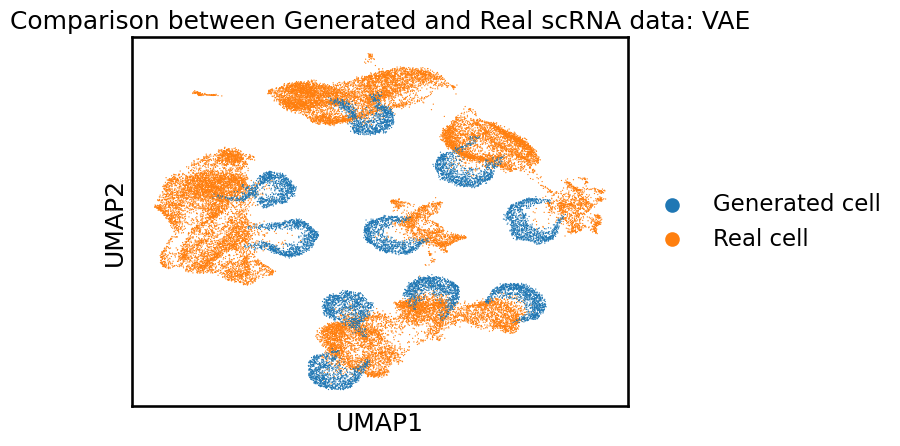

In [41]:
adata_vae = ad.AnnData(X=X_vae_gen,var=adata_sub.var.copy())
adata_vae.obs['cell_ontology_class'] = pd.Categorical.from_codes(
    labels_vae,
    categories=adata_sub.obs['cell_ontology_class'].cat.categories
)
adata_vae.obs['source'] = 'Generated cell'
adata_sub.obs['source'] = 'Real cell'

adata_plot_vae = ad.concat(
    [adata_sub,adata_vae],
    join='outer',
    label='batch',
    keys=['real','gen'])

sc.pp.pca(adata_plot_vae, n_comps=50)
sc.pp.neighbors(adata_plot_vae)
sc.tl.umap(adata_plot_vae)

sc.pl.umap(
    adata_plot_vae,
    color='source',
    title = 'Comparison between Generated and Real scRNA data: VAE',
    
)




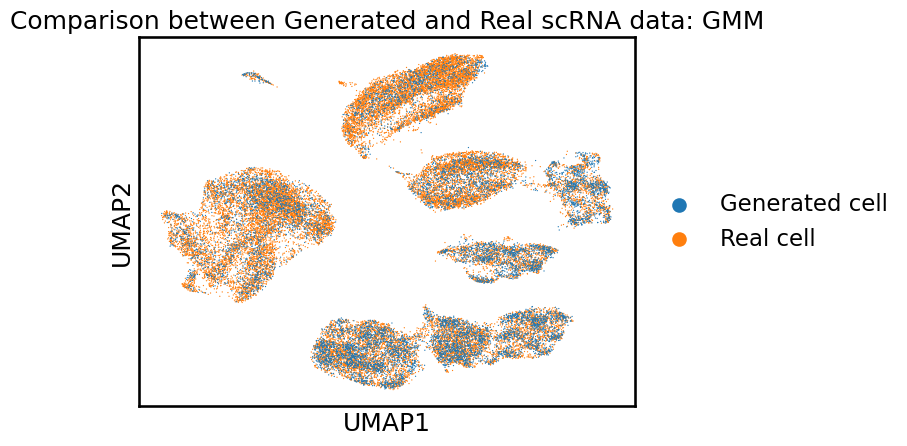

In [42]:
adata_gmm = ad.AnnData(X=X_gmm_gen,var=adata_sub.var.copy())
adata_gmm.obs['cell_ontology_class'] = pd.Categorical.from_codes(
    labels_gmm,
    categories=adata_sub.obs['cell_ontology_class'].cat.categories
)
adata_gmm.obs['source'] = 'Generated cell'
adata_sub.obs['source'] = 'Real cell'

adata_plot_gmm = ad.concat(
    [adata_sub,adata_gmm],
    join='outer',
    label='batch',
    keys=['real','gen'])

sc.pp.pca(adata_plot_gmm, n_comps=50)
sc.pp.neighbors(adata_plot_gmm)
sc.tl.umap(adata_plot_gmm)

sc.pl.umap(
    adata_plot_gmm,
    color='source',
    title = 'Comparison between Generated and Real scRNA data: GMM',
    
)

# Implement GAN for comparison

In [43]:
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset

##############################################
# 1. Label-Conditional GAN
##############################################

class Generator(nn.Module):
    def __init__(self, latent_dim, input_dim, num_classes, label_emb_dim=64, hidden_dim=128):
        super().__init__()
        self.label_emb = nn.Embedding(num_classes, label_emb_dim)
        self.net = nn.Sequential(
            nn.Linear(latent_dim + label_emb_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim),
            # no activation: raw log1p gene space
        )

    def forward(self, z, y):
        ye = self.label_emb(y)
        x = torch.cat([z, ye], dim=1)
        return self.net(x)


class Discriminator(nn.Module):
    def __init__(self, input_dim, num_classes, label_emb_dim=64, hidden_dim=128):
        super().__init__()
        self.label_emb = nn.Embedding(num_classes, label_emb_dim)
        self.net = nn.Sequential(
            nn.Linear(input_dim + label_emb_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1),
            nn.Sigmoid(),
        )

    def forward(self, x, y):
        ye = self.label_emb(y)
        h  = torch.cat([x, ye], dim=1)
        return self.net(h)


##############################################
# 2. Training Loop
##############################################

def train_gan(
    gen: Generator,
    dis: Discriminator,
    X_train: torch.Tensor,
    y_train: torch.Tensor,
    latent_dim: int,
    epochs=100,
    batch_size=320,
    lr=2e-4,
    device='cuda'
):
    gen.to(device); dis.to(device)
    opt_g = torch.optim.Adam(gen.parameters(), lr=lr, betas=(0.5,0.999))
    opt_d = torch.optim.Adam(dis.parameters(), lr=lr, betas=(0.5,0.999))
    loader = DataLoader(TensorDataset(X_train, y_train),
                        batch_size=batch_size, shuffle=True)
    criterion = nn.BCELoss()

    for epoch in range(epochs):
        g_loss_accum = 0.0
        d_loss_accum = 0.0
        for real_x, real_y in loader:
            real_x, real_y = real_x.to(device), real_y.to(device)
            bsz = real_x.size(0)

            # 1) Train Discriminator
            # Real
            real_lbl = torch.ones(bsz,1,device=device)*0.1 + 0.9
            pred_real = dis(real_x, real_y)
            loss_real = criterion(pred_real, real_lbl)

            # Fake
            z = torch.randn(bsz, latent_dim, device=device)
            fake_x = gen(z, real_y)
            fake_lbl = torch.zeros(bsz,1,device=device)*0.1 
            pred_fake = dis(fake_x.detach(), real_y)
            loss_fake = criterion(pred_fake, fake_lbl)

            loss_d = (loss_real + loss_fake) * 0.5
            opt_d.zero_grad(); loss_d.backward(); opt_d.step()
            d_loss_accum += loss_d.item()

            # 2) Train Generator
            pred_fake_for_g = dis(fake_x, real_y)
            loss_g = criterion(pred_fake_for_g, real_lbl)  # wants D(fake)=1
            opt_g.zero_grad(); loss_g.backward(); opt_g.step()
            g_loss_accum += loss_g.item()

        print(f"Epoch {epoch+1}: D_loss={d_loss_accum/len(loader):.4f}, G_loss={g_loss_accum/len(loader):.4f}")

    return gen, dis


##############################################
# 3. Sampling Function
##############################################

def generate_gan(gen: Generator, num_per_class: int, num_classes: int, latent_dim: int, device='cuda'):
    gen.eval()
    all_samples = []
    all_labels  = []
    with torch.no_grad():
        for cls in range(num_classes):
            z = torch.randn(num_per_class, latent_dim, device=device)
            y = torch.full((num_per_class,), cls, dtype=torch.long, device=device)
            x_gen = gen(z, y)
            all_samples.append(x_gen.cpu().numpy())
            all_labels.extend([cls]*num_per_class)

    X_gen = np.vstack(all_samples)
    y_gen = np.array(all_labels, dtype=int)
    return X_gen, y_gen


In [44]:
# Convert sparse matrix to dense
X = adata_sub.X
if scipy.sparse.issparse(X):
    X = X.toarray()

labels = adata_sub.obs['cell_ontology_class'].values
le = LabelEncoder()
labels_encoded = le.fit_transform(labels)

# parameter for config
config.input_dim = X.shape[1]
config.num_classes = len(np.unique(labels_encoded))

# Split data
X_train, X_val, y_train, y_val = train_test_split(
    X, labels_encoded,
    test_size=0.2,
    random_state=42,
    stratify=labels_encoded
)

In [45]:
device = config.device
Xt = torch.tensor(X_train, dtype=torch.float32).to(device)
yt = torch.tensor(y_train, dtype=torch.long).to(device)

latent_dim = 128
gen = Generator(latent_dim, config.input_dim, config.num_classes)
dis = Discriminator(config.input_dim, config.num_classes)
gen, dis = train_gan(gen, dis, Xt, yt, latent_dim,
                     epochs=1000, batch_size=config.batch_size, lr=1e-4, device=device)


Epoch 1: D_loss=0.4643, G_loss=0.7915
Epoch 2: D_loss=0.3347, G_loss=1.0950
Epoch 3: D_loss=0.6826, G_loss=0.9116
Epoch 4: D_loss=0.5324, G_loss=1.1945
Epoch 5: D_loss=0.4353, G_loss=1.1943
Epoch 6: D_loss=0.5629, G_loss=0.8694
Epoch 7: D_loss=0.5095, G_loss=1.0091
Epoch 8: D_loss=0.5221, G_loss=1.0505
Epoch 9: D_loss=0.5081, G_loss=1.0277
Epoch 10: D_loss=0.5554, G_loss=0.9749
Epoch 11: D_loss=0.5784, G_loss=0.9717
Epoch 12: D_loss=0.6378, G_loss=0.8914
Epoch 13: D_loss=0.6446, G_loss=0.8669
Epoch 14: D_loss=0.6263, G_loss=0.8983
Epoch 15: D_loss=0.6207, G_loss=0.9090
Epoch 16: D_loss=0.6371, G_loss=0.8688
Epoch 17: D_loss=0.6283, G_loss=0.8746
Epoch 18: D_loss=0.6237, G_loss=0.8812
Epoch 19: D_loss=0.6249, G_loss=0.8478
Epoch 20: D_loss=0.6319, G_loss=0.8573
Epoch 21: D_loss=0.6347, G_loss=0.8526
Epoch 22: D_loss=0.6116, G_loss=0.8595
Epoch 23: D_loss=0.6323, G_loss=0.8776
Epoch 24: D_loss=0.5953, G_loss=0.9007
Epoch 25: D_loss=0.6736, G_loss=0.8183
Epoch 26: D_loss=0.6090, G_loss=0.

Epoch 802: D_loss=0.6941, G_loss=0.7183
Epoch 803: D_loss=0.6991, G_loss=0.6970
Epoch 804: D_loss=0.6896, G_loss=0.7112
Epoch 805: D_loss=0.6890, G_loss=0.7134
Epoch 806: D_loss=0.6948, G_loss=0.7212
Epoch 807: D_loss=0.6933, G_loss=0.6992
Epoch 808: D_loss=0.6834, G_loss=0.7126
Epoch 809: D_loss=0.6923, G_loss=0.6961
Epoch 810: D_loss=0.6907, G_loss=0.7115
Epoch 811: D_loss=0.6887, G_loss=0.7160
Epoch 812: D_loss=0.6927, G_loss=0.7192
Epoch 813: D_loss=0.6852, G_loss=0.7244
Epoch 814: D_loss=0.6833, G_loss=0.7151
Epoch 815: D_loss=0.7027, G_loss=0.7108
Epoch 816: D_loss=0.6880, G_loss=0.7116
Epoch 817: D_loss=0.7005, G_loss=0.7098
Epoch 818: D_loss=0.6942, G_loss=0.7238
Epoch 819: D_loss=0.6855, G_loss=0.7060
Epoch 820: D_loss=0.6955, G_loss=0.7090
Epoch 821: D_loss=0.6862, G_loss=0.7065
Epoch 822: D_loss=0.6947, G_loss=0.7135
Epoch 823: D_loss=0.6908, G_loss=0.7139
Epoch 824: D_loss=0.6955, G_loss=0.7137
Epoch 825: D_loss=0.6971, G_loss=0.7037
Epoch 826: D_loss=0.6898, G_loss=0.7227


In [46]:
X_gan_gen, labels_gan = generate_gan(gen, num_per_class=1000,
                                     num_classes=config.num_classes,
                                     latent_dim=latent_dim,
                                     device=device)

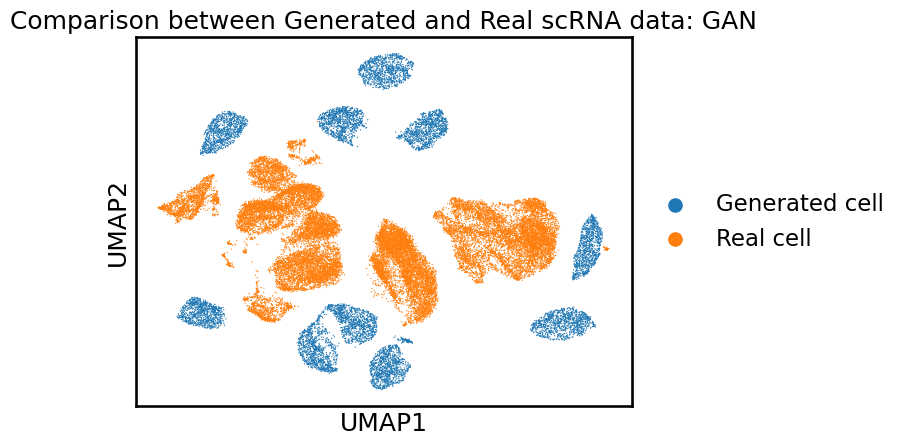

In [47]:
adata_gan = ad.AnnData(X=X_gan_gen,var=adata_sub.var.copy())
adata_gan.obs['cell_ontology_class'] = pd.Categorical.from_codes(
    labels_gan,
    categories=adata_sub.obs['cell_ontology_class'].cat.categories
)
adata_gan.obs['source'] = 'Generated cell'
adata_sub.obs['source'] = 'Real cell'

adata_plot_gan = ad.concat(
    [adata_sub,adata_gan],
    join='outer',
    label='batch',
    keys=['real','gen'])

sc.pp.pca(adata_plot_gan, n_comps=50)
sc.pp.neighbors(adata_plot_gan)
sc.tl.umap(adata_plot_gan)

sc.pl.umap(
    adata_plot_gan,
    color='source',
    title = 'Comparison between Generated and Real scRNA data: GAN',
    
)

In [ ]:
classwise_energy_distance(real_data=X, generated_data=X_gan_gen, labels_encoded=labels_encoded, generated_labels=labels_gan)


MMD (per class):
Class B cell: 0.0545
Class T cell: 0.0868
Class basal cell of epidermis: 0.1052
Class chondrocyte: 0.1554
Class endothelial cell: 0.1628
Class fibroblast: 0.0981
Class keratinocyte: 0.0825
Class macrophage: 0.1597
Class mesenchymal progenitor cell: 0.1487
Class mesenchymal stem cell: 0.1634


0.12170605659484864

In [48]:
metrics = evaluate_all(
    real_data    = adata_sub.X.toarray(),
    gen_data     = X_gan_gen,
    real_labels  = labels_encoded,
    gen_labels   = labels_gan,
    adata_real   = adata_sub,
    adata_gen    = adata_gan
)

/opt/conda/lib/python3.11/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/opt/conda/lib/python3.11/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Spearman SCC: 0.1206
MMD:          0.3231
RF AUC:       1.0000
KNN Acc:      0.9995, KNN AUC: 1.0000


# Training for student-t distribution

In [27]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import numpy as np

##############################################
# 1. CONFIGURATION 
##############################################

class Config:
    # Data params
    batch_size = 320
    num_timesteps = 1000
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Model params
    input_dim = None  # set after loading data
    num_classes = None  # set after encoding labels
    hidden_dim = 512
    time_emb_dim = 128
    label_emb_dim = 128
    num_res_blocks = 6
    lr = 1e-3
    max_epochs = 1000

    # Early stopping
    patience = 20

    # Sampling params for Student-t prior
    student_prior_df    = 15     # degrees of freedom: 15 work best
    student_prior_loc   = 0.0   # center
    student_prior_scale = 1.0   # scale (analogous to σ)
    clip_std            = 4.0   # how many σ to clamp extremes by

    # Noise scheduler
    schedule_type = 'linear'

config = Config()


##############################################
# 3. MODEL IMPLEMENTATION (unchanged)
##############################################
# … your SinusoidalPosEmb, ResidualBlock, DenseBatchNorm, StableDiffusion, etc. …


##############################################
# 4. DIFFUSION PROCESS WITH STUDENT-T PRIOR
##############################################

class DiffusionProcessStudentT:
    def __init__(
        self,
        input_dim,
        num_timesteps=1000,
        beta_start=1e-5,
        beta_end=0.02,
        schedule_type=config.schedule_type,
        df=config.student_prior_df,
        loc=config.student_prior_loc,
        scale=config.student_prior_scale,
        clip_std=config.clip_std
    ):
        # schedule exactly as before
        self.input_dim = input_dim
        self.num_timesteps = num_timesteps

        if schedule_type == 'linear':
            beta = torch.linspace(beta_start, beta_end, num_timesteps)
        elif schedule_type == 'cosine':
            beta = self._cosine_schedule(num_timesteps)
        else:
            raise ValueError("Unsupported schedule type. Use 'linear' or 'cosine'.")

        self.beta = beta
        self.alpha = 1 - beta
        self.alpha_bar = torch.cumprod(self.alpha, dim=0)

        # set up Student-t
        self.studentt = torch.distributions.StudentT(df, loc=loc, scale=scale)
        self.clip_std = clip_std

    def _cosine_schedule(self, num_timesteps, s=0.008):
        steps = torch.arange(num_timesteps + 1) / num_timesteps
        alpha_bar = torch.cos((steps + s) / (1 + s) * torch.pi * 0.5) ** 2
        alpha_bar = alpha_bar / alpha_bar[0]
        alpha_bar[-1] = 0.0
        beta = 1 - alpha_bar[1:] / alpha_bar[:-1]
        return torch.clamp(beta, 1e-4, 0.9999)

    def add_noise(self, x, t):
        """
        x: clean data (in linear space)
        t: timestep index
        returns noisy_x, noise
        """
        # sample heavy-tailed noise
        noise = self.studentt.sample(x.shape).to(x.device)
        # clamp extreme tails
        # mean = self.studentt.mean.to(x.device)
        # std  = self.studentt.stddev.to(x.device)
        # noise = torch.clamp(noise,
        #                     mean - self.clip_std * std,
        #                     mean + self.clip_std * std)

        # standard diffusion mixing
        alpha_bar_t = self.alpha_bar[t].view(-1, *([1] * (x.dim()-1)))
        noisy_x = torch.sqrt(alpha_bar_t) * x + torch.sqrt(1 - alpha_bar_t) * noise
        return noisy_x, noise


##############################################
# 5. DATASET FOR STUDENT-T DIFFUSION
##############################################

class DiffusionDatasetStudentT(Dataset):
    def __init__(self, X, labels, diffusion, num_timesteps):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.labels = torch.tensor(labels, dtype=torch.long)
        self.diffusion = diffusion
        self.num_timesteps = num_timesteps

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        x = self.X[idx]
        t = torch.randint(0, self.num_timesteps, ()).long()
        label = self.labels[idx]
        x_noisy, noise = self.diffusion.add_noise(x, t)
        return (x_noisy, t, label), noise

def prepare_dataset_studentt(X, labels, diffusion, batch_size, num_timesteps=1000):
    dataset = DiffusionDatasetStudentT(X, labels, diffusion, num_timesteps)
    return DataLoader(dataset,
                      batch_size=batch_size,
                      shuffle=True,
                      pin_memory=True)


##############################################
# 6. SAMPLING WITH STUDENT-T PRIOR
##############################################

def sample_studentt(model, diffusion, labels, num_samples, device='cuda'):
    """
    Start from a Student-t prior instead of Gaussian.
    """
    # initial draws from Student-t
    studentt = torch.distributions.StudentT(
        config.student_prior_df,
        loc=config.student_prior_loc,
        scale=config.student_prior_scale
    )
    samples = studentt.sample((num_samples, diffusion.input_dim)).to(device)

    for t in reversed(range(diffusion.num_timesteps)):
        timestep = torch.full((num_samples,), t, dtype=torch.long, device=device)

        # predict residual
        pred_noise = torch.zeros_like(samples)
        model.eval()
        with torch.no_grad():
            pred_noise = model(samples, timestep, labels)

        # diffusion update
        alpha_bar_t    = diffusion.alpha_bar[t].to(device)
        alpha_bar_prev = diffusion.alpha_bar[t-1].to(device) if t > 0 else torch.tensor(1.0, device=device)
        alpha_t        = alpha_bar_t / alpha_bar_prev
        coef           = diffusion.beta[t].to(device) / torch.sqrt(1 - alpha_bar_t)

        samples = (samples - coef * pred_noise) / torch.sqrt(alpha_t)
        if t > 0:
            # Gaussian noise for the reverse process
            noise = torch.randn_like(samples)
            samples += torch.sqrt(diffusion.beta[t].to(device)) * noise

    return samples.cpu().numpy()

def generate_synthetic_data_studentt(
    model,
    diffusion,
    labels_encoded: np.ndarray,
    num_samples_per_class: int,
    device: str = 'cuda'
):
    """
    For each class in labels_encoded, generate `num_samples_per_class`
    by running the reverse diffusion from a Student-t prior.
    Returns:
      generated_data: np.ndarray [N_total x input_dim]
      generated_labels: np.ndarray [N_total]
    """
    model.eval()
    unique_labels = np.unique(labels_encoded)
    all_samples = []
    all_labels  = []

    for cls in unique_labels:
        # create a tensor of this class label
        label_tensor = torch.full(
            (num_samples_per_class,),
            cls,
            dtype=torch.long,
            device=device
        )
        # sample
        samples = sample_studentt(
            model,
            diffusion,
            label_tensor,
            num_samples_per_class,
            device=device
        )  # returns numpy array [num_samples_per_class x input_dim]
        all_samples.append(samples)
        all_labels.extend([cls] * num_samples_per_class)

    generated_data   = np.vstack(all_samples)
    generated_labels = np.array(all_labels, dtype=int)
    return generated_data, generated_labels


In [28]:
# Convert sparse matrix to dense
X = adata_sub.X
if scipy.sparse.issparse(X):
    X = X.toarray()

labels = adata_sub.obs['cell_ontology_class'].values
le = LabelEncoder()
labels_encoded = le.fit_transform(labels)

# parameter for config
config.input_dim = X.shape[1]
config.num_classes = len(np.unique(labels_encoded))

# Split data
X_train, X_val, y_train, y_val = train_test_split(
    X, labels_encoded,
    test_size=0.2,
    random_state=42,
    stratify=labels_encoded
)

In [29]:
if __name__ == "__main__":
    # Initialize diffusion process (normal prior)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    diffusion = DiffusionProcessStudentT(config.input_dim,
                                 num_timesteps=config.num_timesteps,
                                 schedule_type='linear')
    train_loader = prepare_dataset_studentt(X_train, y_train, diffusion, batch_size=config.batch_size)
    val_loader   = prepare_dataset_studentt(X_val,   y_val,   diffusion, batch_size=config.batch_size)

    # Initialize model
    model = StableDiffusion(
        input_dim=config.input_dim,
        num_classes=config.num_classes,
        hidden_dim=config.hidden_dim,
        time_emb_dim=config.time_emb_dim,
        label_emb_dim=config.label_emb_dim,
        num_res_blocks=config.num_res_blocks
    ).to(config.device)

    # Train with normal prior data preparation
    train_losses, val_losses = train_loop(config=config,
                                            model=model,
                                            train_loader=train_loader,
                                            val_loader=val_loader)

    # Save the trained model weights
    torch.save(model.state_dict(), './weight/stable_diffusion_student_prior.pth')
    print("Model trained and saved with student prior.")

    # Load your trained model weights (normal prior model)
    model.load_state_dict(torch.load('./weight/stable_diffusion_student_prior.pth', map_location=device))
    model.eval()

    # Generate synthetic data per class
    num_samples_per_class = 5000
    generated_data_student, generated_labels_student = generate_synthetic_data_studentt(model, diffusion, labels_encoded, num_samples_per_class, device)



Epoch 1/1000 - Train Loss: 1.057410 - Val Loss: 0.589613
Epoch 2/1000 - Train Loss: 0.438680 - Val Loss: 0.374528
Epoch 3/1000 - Train Loss: 0.320051 - Val Loss: 0.317266
Epoch 4/1000 - Train Loss: 0.283337 - Val Loss: 0.285809
Epoch 5/1000 - Train Loss: 0.262169 - Val Loss: 0.280308
Epoch 6/1000 - Train Loss: 0.250271 - Val Loss: 0.260845
Epoch 7/1000 - Train Loss: 0.240115 - Val Loss: 0.258668
Epoch 8/1000 - Train Loss: 0.233754 - Val Loss: 0.261956
Epoch 9/1000 - Train Loss: 0.229934 - Val Loss: 0.261891
Epoch 10/1000 - Train Loss: 0.224539 - Val Loss: 0.258607
Epoch 11/1000 - Train Loss: 0.211520 - Val Loss: 0.221879
Epoch 12/1000 - Train Loss: 0.205225 - Val Loss: 0.219395
Epoch 13/1000 - Train Loss: 0.206813 - Val Loss: 0.217403
Epoch 14/1000 - Train Loss: 0.205138 - Val Loss: 0.214416
Epoch 15/1000 - Train Loss: 0.203480 - Val Loss: 0.216495
Epoch 16/1000 - Train Loss: 0.201933 - Val Loss: 0.226046
Epoch 17/1000 - Train Loss: 0.199956 - Val Loss: 0.219604
Epoch 18/1000 - Train L

/tmp/ipykernel_932778/4155248300.py:32: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('./weight/stable_diffusion_student_prior.pth', map_loc

In [30]:
classwise_energy_distance(real_data=X, generated_data=generated_data_student, labels_encoded=labels_encoded, generated_labels=generated_labels_student)


Energy Distance (per class):
Class B cell: 0.1864
Class T cell: 0.1916
Class basal cell of epidermis: 0.2330
Class chondrocyte: 0.1949
Class endothelial cell: 0.2987
Class fibroblast: 0.2065
Class keratinocyte: 0.2942
Class macrophage: 0.5285
Class mesenchymal progenitor cell: 0.1671
Class mesenchymal stem cell: 0.2455


0.25463708741735247

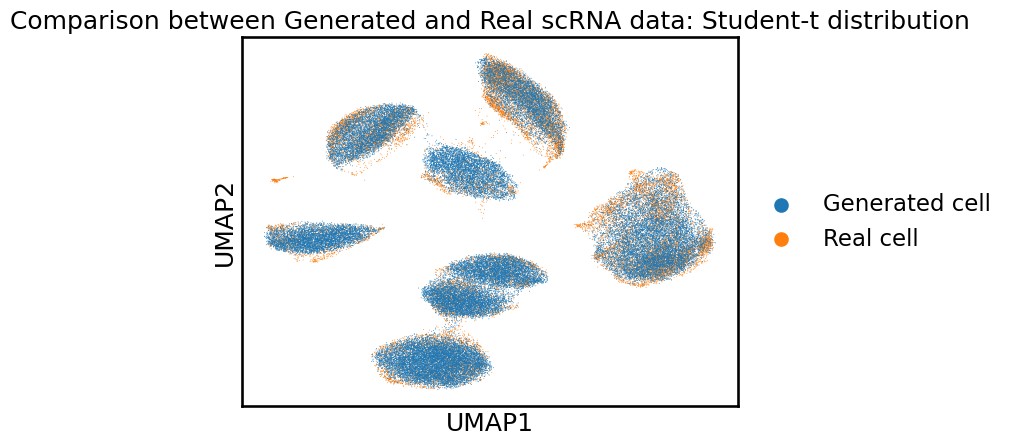

In [31]:
adata_student = ad.AnnData(X=generated_data_student,var=adata_sub.var.copy())
adata_student.obs['cell_ontology_class'] = pd.Categorical.from_codes(
    generated_labels_student,
    categories=adata_sub.obs['cell_ontology_class'].cat.categories
)
adata_student.obs['source'] = 'Generated cell'
adata_sub.obs['source'] = 'Real cell'

adata_plot_student = ad.concat(
    [adata_sub,adata_student],
    join='outer',
    label='batch',
    keys=['real','gen'])

sc.pp.pca(adata_plot_student, n_comps=50)
sc.pp.neighbors(adata_plot_student)
sc.tl.umap(adata_plot_student)

sc.pl.umap(
    adata_plot_student,
    color='source',
    title = 'Comparison between Generated and Real scRNA data: Student-t distribution',
    
)




In [32]:
metrics = evaluate_all(
    real_data    = adata_sub.X.toarray(),
    gen_data     = generated_data_student,
    real_labels  = labels_encoded,
    gen_labels   = generated_labels_student,
    adata_real   = adata_sub,
    adata_gen    = adata_student
)

/opt/conda/lib/python3.11/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/opt/conda/lib/python3.11/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Spearman SCC: 0.0995
MMD:          0.0063
RF AUC:       1.0000
KNN Acc:      0.7020, KNN AUC: 0.8210


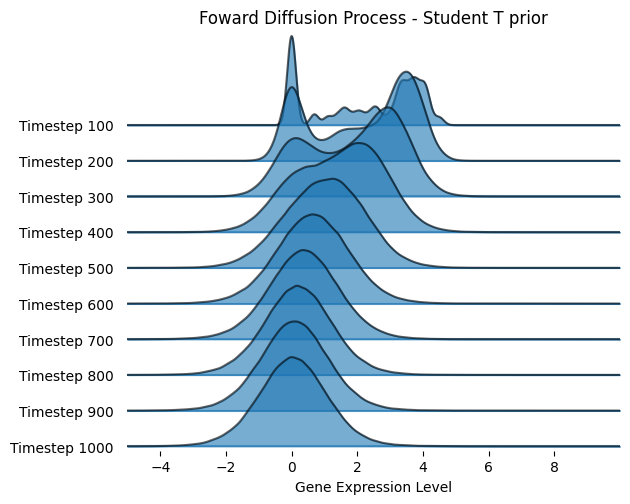

In [9]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from joypy import joyplot

X = adata_sub.X
if scipy.sparse.issparse(X):
    X = X.toarray()
x0 = torch.tensor(X[0], dtype=torch.float32)

diff = DiffusionProcessStudentT(input_dim=x0.shape[0])
n_draws   = 2000

all_xt = []
for t in range(0,config.num_timesteps,100):
    xt_samples = []
    t_tensor   = torch.tensor([t], dtype=torch.long)
    for _ in range(n_draws):
        # add_noise works on a single sample here
        x_t, _ = diff.add_noise(x0, t_tensor)
        xt_samples.append(x_t.numpy())
    all_xt.append(np.concatenate(xt_samples))  # flatten to 1D

# 5) joyplot them exactly like before
fig, axes = joyplot(
    all_xt,
    labels=[f"Timestep {(t+1)*100}" for t in range(len(all_xt))],  # Labels for each timestep
    grid=False,
    ylim='auto',
    x_range=(-5,10),
    alpha=0.6
)

# Customize the plot with title and labels
plt.title('Foward Diffusion Process - Student T prior')
plt.xlabel('Gene Expression Level')
plt.ylabel('Density')
plt.show()




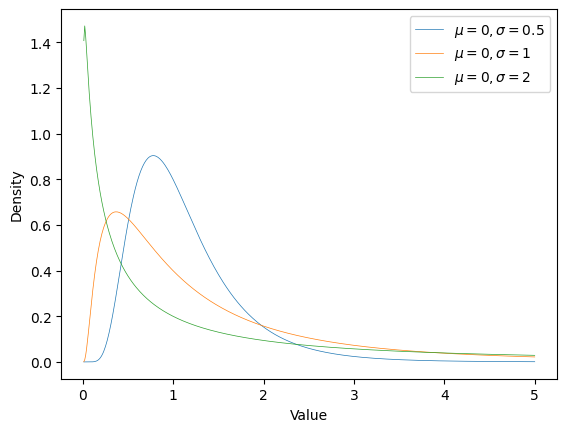

In [23]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import lognorm

# Define parameters
mus = [0, 0, 0]
sigmas = [0.5, 1, 2]
labels = [r'$\mu=0, \sigma=0.5$', r'$\mu=0, \sigma=1$', r'$\mu=0, \sigma=2$']

# X-axis values (avoid zero)
x = np.linspace(0.01, 5, 500)

# Plot each density
plt.figure()
for mu, sigma, label in zip(mus, sigmas, labels):
    # lognorm.pdf takes `s` = sigma, and `scale=exp(mu)`
    pdf = lognorm.pdf(x, s=sigma, scale=np.exp(mu))
    plt.plot(x, pdf,lw=0.5, label=label)

plt.xlabel('Value')
plt.ylabel('Density')
# plt.title('Log-Normal Distribution')
plt.legend()
plt.show()

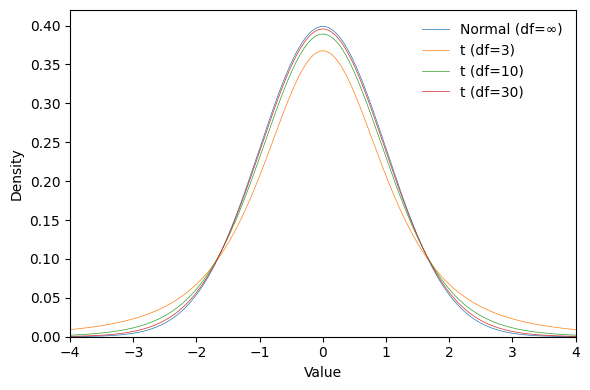

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, t

# 1. Define x-axis
x = np.linspace(-4, 4, 500)

# 2. Compute densities
normal_pdf = norm.pdf(x, loc=0, scale=1)

t_dfs = [3, 10, 30]
t_pdfs = {df: t.pdf(x, df, loc=0, scale=1) for df in t_dfs}

# 3. Plot
plt.figure(figsize=(6,4))

plt.plot(x, normal_pdf, lw=0.5,label='Normal (df=∞)')
plt.plot(x, t_pdfs[3],   lw=0.5,    label='t (df=3)')
plt.plot(x, t_pdfs[10],  lw=0.5, label='t (df=10)')
plt.plot(x, t_pdfs[30],   lw=0.5,  label='t (df=30)')

# 4. Styling
plt.xlim(-4, 4)
plt.ylim(0, 0.42)
plt.xlabel('Value')
plt.ylabel('Density')
# plt.title('Normal vs. Student’s t Distributions')
plt.legend(frameon=False)
plt.tight_layout()

# 5. Show
plt.show()
